# 0.0. IMPORTS

In [92]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
import datetime
from tabulate import tabulate
from scipy import stats as ss
from IPython.core.display import HTML
from IPython.display import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
# import warnings
# warnings.filterwarnings('ignore')

# 0.1. Helper Functions

In [15]:
def cramer_v(x,y):
    # metodo utilizado: cruamer v
    # vai de 0 a 1
    # quanto mais perto do 0 menor a correlacao
    # quanto mais perto do 1 maior a correlacao
    cm = pd.crosstab(x, y).to_numpy()  # cria uma matrix de confusao entre as variaveis categoricas
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display(HTML(',style..container {width:100% !importante;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

# 0.2. Loading Data

In [16]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False) # raw e pq acabou de ler o arqivo e nao fez nnhuma alteracao ainda
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge = junta os dois dataframes em um so
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [17]:
df_sales_raw[df_sales_raw['Store'] == 1]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1115,1,4,2015-07-30,5020,546,1,1,0,1
2230,1,3,2015-07-29,4782,523,1,1,0,1
3345,1,2,2015-07-28,5011,560,1,1,0,1
4460,1,1,2015-07-27,6102,612,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1011635,1,6,2013-01-05,4997,635,1,0,0,1
1012750,1,5,2013-01-04,4486,619,1,0,0,1
1013865,1,4,2013-01-03,4327,578,1,0,0,1
1014980,1,3,2013-01-02,5530,668,1,0,0,1


In [18]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
194525,516,6,2015-02-07,4838,706,1,0,0,0,a,c,20.0,NaN,NaN,1,35.0,2010.0,"Mar,Jun,Sept,Dec"


# 1.0. STEP 01 - DATA DESCRIPTION

In [19]:
df1 = df_raw.copy() # copia dos dados originais, caso tenho um erro nessa sessao, os dados da sessao anterios estao salvos.

## 1.1. Rename Columns

In [20]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [21]:
# alterando os nomes das colunas
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

# funcao que altera o nome das colunas para o tipo snakecase
snakecase = lambda x: inflection.underscore(x)

# map faz o mapeamento da funcao snakecase em todas as palavras da variavel cols_old
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

In [22]:
df1.columns # as colunas estao no tipo snakecase agora

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [23]:
# saber qal e o amanho de linhas e colunas
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [24]:
df1['date'] = pd.to_datetime(df1['date']) # alterando o tipo da coluna date para date time
df1.dtypes # mostra os tipos das colunas

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [25]:
df1.isna().sum() # verifica a quantidade de na em cada coluna

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA using business logic

In [26]:
# competition_distance 
# Nesta coluna, NA significa q a loja nao tem competicao proxima ou entao q a loja competidora esta muito longe. 
#Com isso, para remover os NAs desta coluna, podemos colocar uma distancia maior do que a distancia maxima entre as lojas. 

#funcao q substitui todos os NAs das colunas por uma distancia maior do que a distancia maxima entre as lojas, neste caso, 
#200000
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
#obs a funcao math.isnan so funcionanna funcao lambda mais apply, sozinho a funcao math.isnan nao funciona

# competition_open_since_month
# Nesta coluna, se for NA, copia-se o mes da data de venda daquela linha, da coluna date, para a coluna competition_open_since_month.
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else
                                                          x['competition_open_since_month'], axis =1)
#obs: tem o nome das colunas do lado do x nesse pois usa-se mais de uma coluna 

#competition_open_since_year 
# Nesta coluna, se for NA, copia-se o ano da data de venda daquela linha, da coluna date, para a coluna competition_open_since_year.
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else
                                                          x['competition_open_since_year'], axis =1)
                    
#promo2_since_week     
# Nesta coluna, se for NA, copia-se a semana da data de venda daquela linha, da coluna date, para a coluna promo2_since_week .
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else
                                                          x['promo2_since_week'], axis =1)
#promo2_since_year  
# Nesta coluna, se for NA, copia-se a ano da data de venda daquela linha, da coluna date, para a coluna promo2_since_week .
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else
                                                          x['promo2_since_year'], axis =1)

#promo_interval   
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True) # substitui os NAs da coluna por 0, e inplace = True serve deixar essa substituicao como definitivo

df1['month_map'] = df1['date'].dt.month.map(month_map) # cria-se uma nova coluna, onde se copia os meses da coluna date, 
#de cada linha, para esta nova coluna, e transforma estes meses em string  com o auxulio do dicionario criado acima e da funcao .map.

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 
                                                                       1 if x['month_map'] in x['promo_interval'].split(',') else 
                                                                       0,axis = 1)
# split quebra o array separado por virgula e transforma em lsita
#cria-se uma coluna nova chamada is_promo, onde e criada baseada em duas condicoes:

#primeira:
# Se o mes da coluna 'month_map estiver incluso na coluna promo_interval, o valor da coluna is_promo e 1, 
# Se o mes da coluna 'month_map nao estiver incluso na coluna promo_interval, o valor da coluna is_promo e 0.

#segunda
# Se o valor da linha da coluna 'promo_interval for 0, o valor da coluna is_promo e 0,
# Se o valor da linha da coluna 'promo_interval NAO for 0, o valor da coluna is_promo e 1.


In [27]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [28]:
df1.sample(5).T

,472676,49493,41126,104591,182804
store,702,434,987,897,1060
day_of_week,7,3,4,3,3
date,2014-05-04 00:00:00,2015-06-17 00:00:00,2015-06-25 00:00:00,2015-04-29 00:00:00,2015-02-18 00:00:00
sales,0,9948,4945,3555,7244
customers,0,718,719,370,846
open,0,1,1,1,1
promo,0,1,0,1,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,a,c,c,a


### 1.5.1 Fillout NA (alternativa criada por mim tbm usando logica de negocios)

In [24]:
# # competition_open_since_month
# Nesta coluna, se for NA, copia-se o primeiro mes de compra da coluna data, referente a cada valor de store,
#para a coluna competition_open_since_month.
first_month_year = df1[['store', 'date']].groupby('store').min().reset_index()
first_month_year.columns = ['store', 'first_month_year']
df2 = pd.merge(df1,first_month_year,on='store',how='inner')

df2['competition_open_since_month'] = df2.apply(lambda x: x['first_month_year'].month if math.isnan(x['competition_open_since_month']) else
                                                          x['competition_open_since_month'], axis =1)

# # competition_open_since_year
# Nesta coluna, se for NA, copia-se o primeiro ano de compra da coluna data, referente a cada valor de store,
#para a coluna competition_open_since_year.
df2['competition_open_since_year'] = df2.apply(lambda x: x['first_month_year'].year if math.isnan(x['competition_open_since_year']) else
                                                          x['competition_open_since_year'], axis =1)

#promo2_since_week     
# Nesta coluna, se for NA, copia-se a primeira semana de compra da coluna data, referente a cada valor de store,
#para a coluna promo2_since_week .
df2['promo2_since_week'] = df2.apply(lambda x: x['first_month_year'].week if math.isnan(x['promo2_since_week']) else
                                                          x['promo2_since_week'], axis =1)
#promo2_since_year  
# Nesta coluna, se for NA, copia-se o primeiro ano de compra da coluna data, referente a cada valor de store,
#para a coluna competition_open_since_year.
df2['promo2_since_year'] = df2.apply(lambda x: x['first_month_year'].year if math.isnan(x['promo2_since_year']) else
                                                          x['promo2_since_year'], axis =1)


In [16]:
df2[['store', 'date', 'competition_open_since_month', 'competition_open_since_year', 'first_month_year','promo2_since_week', 'promo2_since_year']]

,store,date,competition_open_since_month,competition_open_since_year,first_month_year,promo2_since_week,promo2_since_year
0,1,2015-07-31,9.0,2008.0,2013-01-01,31.0,2015.0
1,1,2015-07-30,9.0,2008.0,2013-01-01,31.0,2015.0
2,1,2015-07-29,9.0,2008.0,2013-01-01,31.0,2015.0
3,1,2015-07-28,9.0,2008.0,2013-01-01,31.0,2015.0
4,1,2015-07-27,9.0,2008.0,2013-01-01,31.0,2015.0
...,...,...,...,...,...,...,...
1017204,1115,2013-01-05,1.0,2013.0,2013-01-01,22.0,2012.0
1017205,1115,2013-01-04,1.0,2013.0,2013-01-01,22.0,2012.0
1017206,1115,2013-01-03,1.0,2013.0,2013-01-01,22.0,2012.0
1017207,1115,2013-01-02,1.0,2013.0,2013-01-01,22.0,2012.0


In [17]:
df2.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week                    0
promo2_since_year                    0
promo_interval                  508031
first_month_year                     0
dtype: int64

## 1.6. Change Types

In [29]:
# Depois de criar ou aletrar colunas e bom checar os tipos das colunas novamente

In [30]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [31]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)

In [32]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [33]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])# seleciona as colunas pelo tipo, neste caso, numericas
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])# exclui as colunas pelo tipo, neste caso, numericas

## 1.7.1 Numerical Atributes

In [34]:
#central tendency - media, mediana
ct1 = pd.DataFrame (num_attributes.apply(np.mean)).T # funcao apply aplica qualquer funcao nas colunas ou linhas da variaves
ct2 = pd.DataFrame (num_attributes.apply(np.median)).T

#dispersion - std, min ,max, range, skew, kurtosis
d1 = pd.DataFrame (num_attributes.apply(np.std)).T
d2 = pd.DataFrame (num_attributes.apply(min)).T
d3 = pd.DataFrame (num_attributes.apply(max)).T
d4 = pd.DataFrame (num_attributes.apply(lambda x: x.max() - x.min())).T # range
d5 = pd.DataFrame (num_attributes.apply(lambda x: x.skew())).T # skew
d6 = pd.DataFrame (num_attributes.apply(lambda x: x.kurtosis())).T # kurtosis

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [35]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.000,1115.000,1114.000,558.430,558.000,321.908,-0.001,-1.201
1,day_of_week,1.000,7.000,6.000,3.998,4.000,1.997,0.002,-1.247
2,sales,0.000,41551.000,41551.000,5773.819,5744.000,3849.924,0.641,1.778
3,customers,0.000,7388.000,7388.000,633.146,609.000,464.412,1.599,7.092
4,open,0.000,1.000,1.000,0.830,1.000,0.376,-1.758,1.091
5,promo,0.000,1.000,1.000,0.382,0.000,0.486,0.488,-1.762
6,school_holiday,0.000,1.000,1.000,0.179,0.000,0.383,1.678,0.815
7,competition_distance,20.000,200000.000,199980.000,5935.443,2330.000,12547.647,10.242,147.790
8,competition_open_since_month,1.000,12.000,11.000,6.787,7.000,3.311,-0.042,-1.233
9,competition_open_since_year,1900.000,2015.000,115.000,2010.325,2012.000,5.516,-7.236,124.071


C:\Users\Igor\anaconda3\envs\Data-Science-Em-Producao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

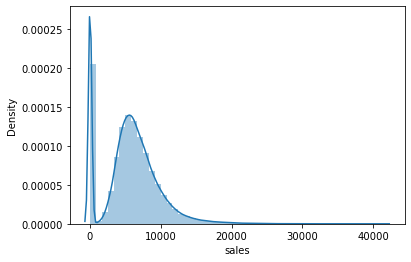

In [36]:
sns.distplot(df1['sales']) # futuramente usar displot ou histplot
# coluna proxima de uma normal, um pouco deslocada para a esquerda pq a media e a mediana sao doferentes e a skew e positiva

C:\Users\Igor\anaconda3\envs\Data-Science-Em-Producao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

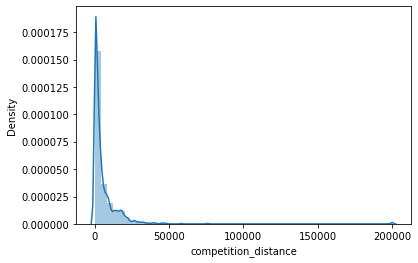

In [37]:
sns.distplot(df1['competition_distance'])
# ao verificar o Descriptive Statistical, checa-se que a skew esta bem alta, super deslocada pra esquerda e a kurtosis 
# esta gigantesca, o q significa que e uma distribuicao tipo puason, onde o tem um pico bem alto no comeco, depois vai caindo,
# e tem uma concentracao muito alta de valores no comeco.
#Isto acontece pq os competidores esta proximos, com distancias pequenas, e concentracao grande perto do 0

## 1.7.2 Categorical Atributes

In [38]:
# para categorical attirbutes usa-se o boxplot, onde mostra todas as medidas de dispercao e central em um lugar so.

In [39]:
cat_attributes.apply(lambda x: x.unique().shape[0])
# funcao lambda que verifica a quantidade dos valores unitarios dos todas as colunas do dataset de uma vez 

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

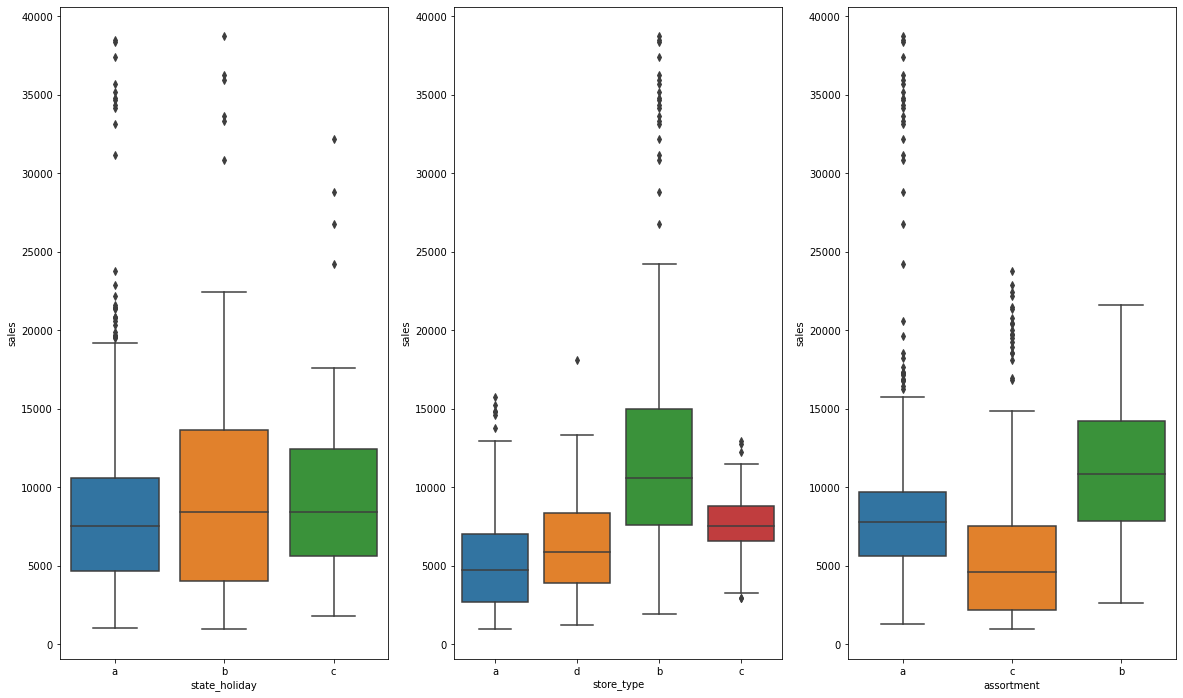

In [40]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

fig = plt.figure(figsize=(20,12)) 

fig.add_subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

fig.add_subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1)

fig.add_subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1)
# x  e a linha de referencia, o nome da categoria
# y e o q uer medir

In [41]:
#funcionamento do boxplot:

# a linha do meio do quadrado colorido e a 50º percentil  ou seja e a mediana
# a linha de baixo do quadrado colorido e a 25º percentil 
# a linha de cima do quadrado colorido e a 75º percentil 
# as linhas extremas sao 0º e 100º percentil (sao os valores minimos e maximos)

# este retangulo e dividido em 4 quartis,
# o 1º quartil esta entre os percentis 0 e 25 
# o 2º quartil esta entre os percentis 25 e 50 
# o 3º quartil esta entre os percentis 50 e 75 
# o 4º quartil esta entre os percentis 75 e 100 

# tudo fora dos valores minimos e maximos sao considerados outlires, q sao considerados como 3 vezes o desvio padrao.

# 2.0. STEP 02 - FEATURE ENGINEERING

In [42]:
df2 = df1.copy()

## 2.1. Mind Map Hyphotesis

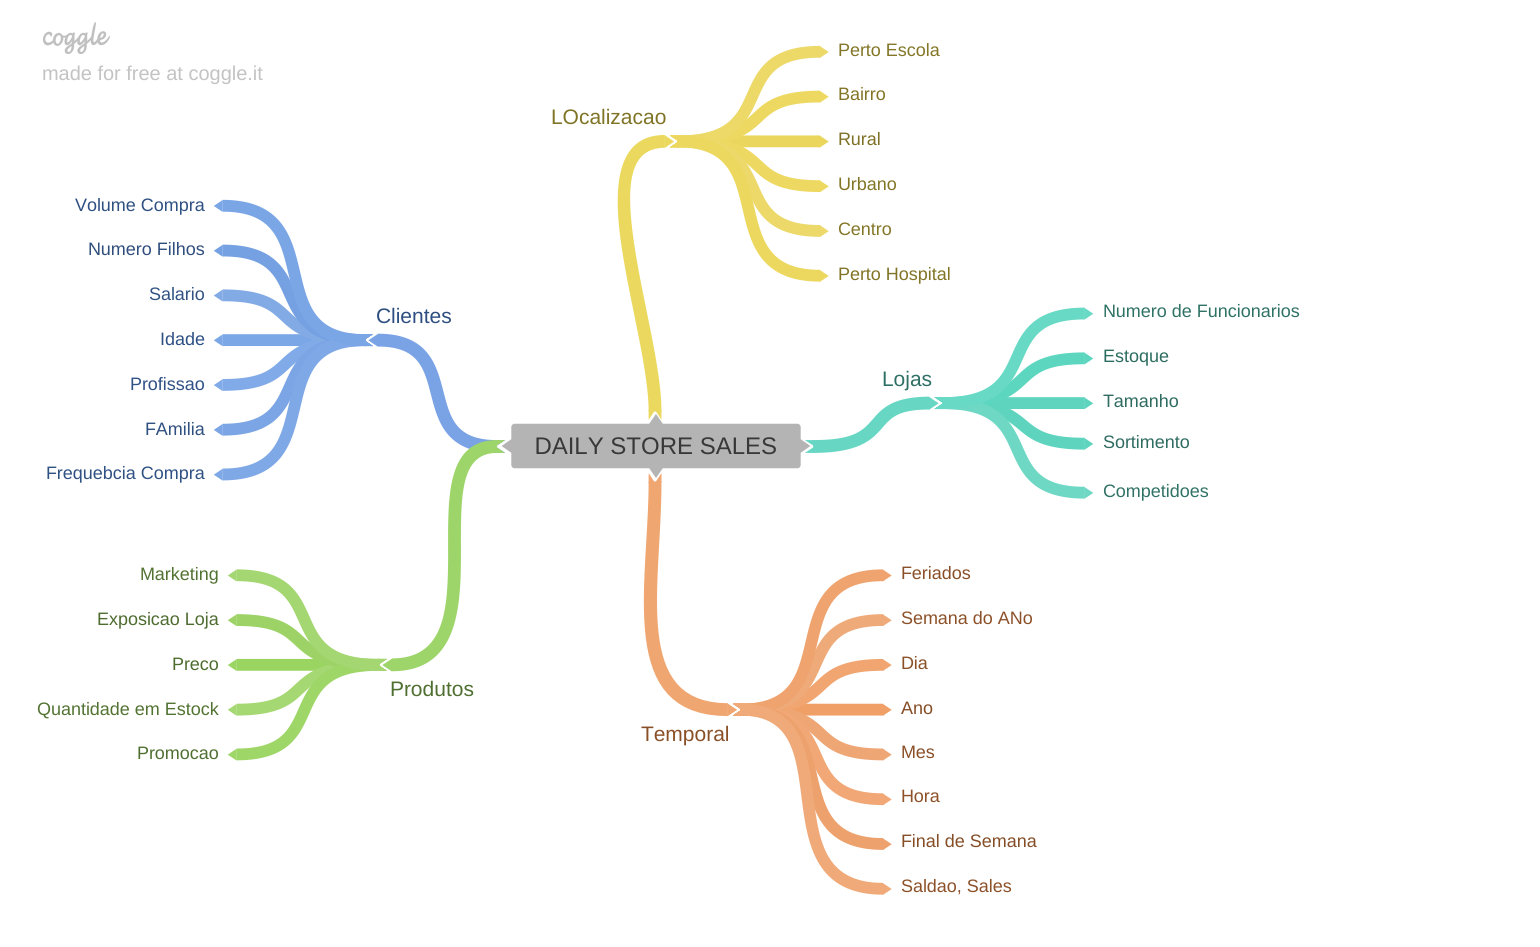

In [43]:
Image('img/MindMapHypothesis.png')

## 2.2. Hyphotesis Creation

### 2.1.1 Store Hypothesis

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortemento deveriam vender mais.

**5.** Lojas com competidores mais proximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.2 Poduct Hypothesis

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoem mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem precos menores nos produtos deveriam vender mais.

**4.** Lojas com promocoes mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promocao deveriam vender mais.

**7.** Lojas com mais promocoes consecutivas deveriam vender mais.

### 2.1.3 Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**5.** Lojas deveriam vender menos aos fins de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2. Hyphotesis Final List

Aki se prioriza as hipoteses.

Para isso verifica-se se tem ou nao o dado disponivel no dataset para fazer a hipotese.

Caso com essas hipoteses o modelo tenha um desempeno ruim, ai sim cria-se novos dados para aplicar as novas hipoteses.

**1.** Lojas com maior sortemento deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promocao deveriam vender mais.

**6.** Lojas com mais promocoes consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11.** Lojas deveriam vender menos aos fins de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [44]:
# Variaveis a serem derivadas da variavel original date

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(np.int64)

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since (calcula,em meses, desde quando a competicao exsite ate a da data de compra)
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], 
                                                                 month = x['competition_open_since_month'], 
                                                                 day = 1), axis=1) # junta 3 colunas separadas (ano, mes e dia) 
                                                                                   # em uma coluna so com as 3 informacoes

df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(np.int64)
# diminui data de compra pela data de competicao, e divide por 30, para manter a granularidade de mes

# promo since ( desde quando tem a promocao ativa)
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) # juntando as colunas 
                                                                                                    # em forma de string
    
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
# transformando a coluna do tipo str para o tipo data.

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(np.int64)
# diminui data de compra pela data de promocao, e divide por 7, para manter a granularidade de semanas


# assortment (trocar as letras por nome por extenso)
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic'    if x == 'a' else
                                                      'extra'    if x == 'b' else
                                                      'extended'                  )

# state holiday (trocar as letras por nome por extenso)
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else
                                                            'Easter holiday' if x == 'b' else
                                                            'Christmas'      if x == 'c' else
                                                            'regular_day'                     )

In [45]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

In [46]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. STEP 03 - VARIABLES FILTER

In [47]:
df3 = df2.copy()

In [48]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Rows Filter

In [49]:
### Restricao de Negocio:

# Open: PQ nao se usa as linhas onde as lojas estao fechadas, pois nao tem venda nessas linhas, logo joga-se fora todas as 
# linhas que tem como valor 0 fora.
#'open' != 0#

# Sales: Excluir as linhas q tem valor 0, pois essas nao sao uteis para predicao.
#'sales' > 0#

df3 = df3[(df3['open'] !=0) & (df3['sales'] >0)]

## 3.2. Columns Selection

In [50]:
### Restricao de Negocio:

#Customers: PQ como se precisa de uma predicao somente para daki a 6 semanas, nao teremos a quantidade de clientes por dia, 
# a partir de hj ate daki a 6 semanas, so temos de hj para traz. Por isso joga-se essa coluna fora.

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# open deletada pq so tem 1 entao nao e relevante, e 'promo_interval', 'month_map' deletadas pq sao colunas auxiliares para
# outras colunas.

In [51]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. STEP 04 - EXPLORATORY DATA ANALYSIS (EDA)

In [52]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales', ylabel='Count'>

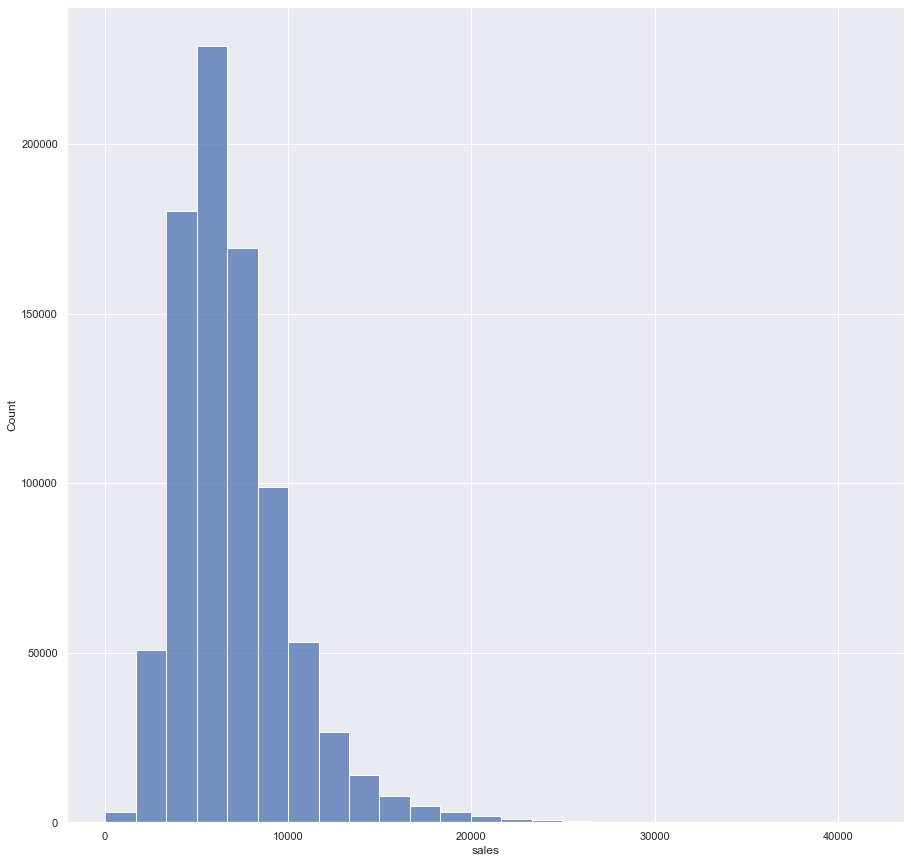

In [53]:
# plotando a variavel resposta
sns.set(rc={"figure.figsize": (15, 15)})
sns.histplot(df4['sales'], bins = 25)
# mais normal a variavel resposta, melhor o algoritmo vai performar
# ela tem um pouco de kurtosis e apresenta um skew positivo, q e a esquerda.

### 4.1.2. Numerical Variable

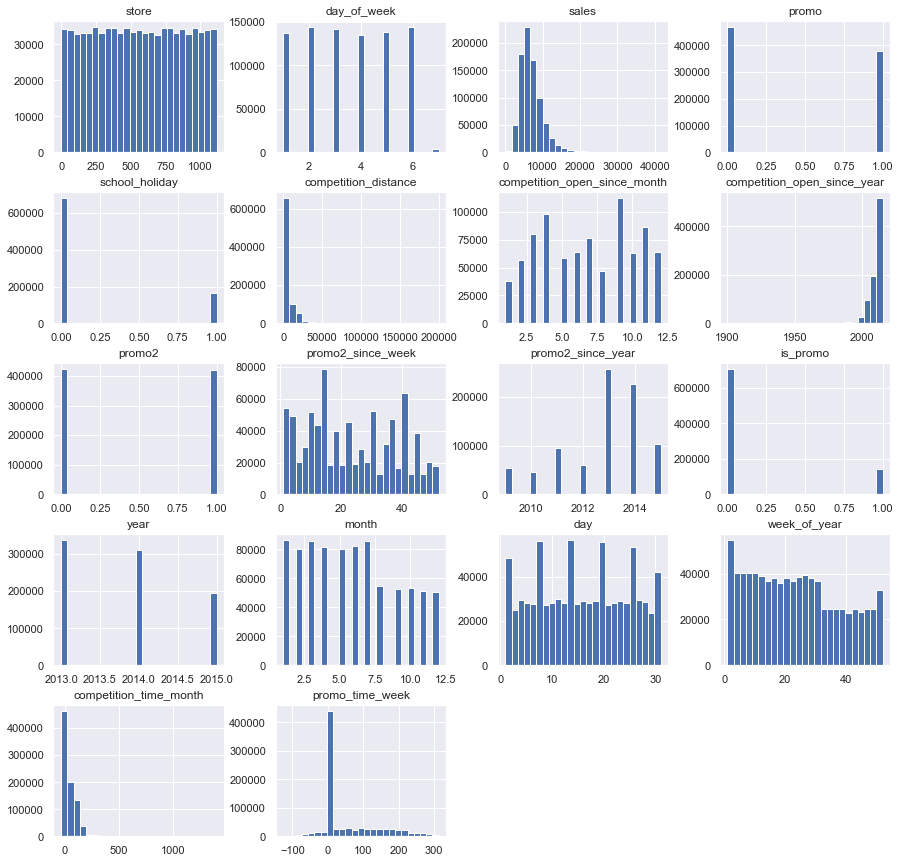

In [54]:
a = df4.select_dtypes(include=['int64', 'float64'])

sns.set(rc={"figure.figsize": (15, 15)})
a.hist(bins = 25);
# variaveis q mostram mais comportamento mais explicativa do fenomeno ela e, apresentando informacao relevante para o aprendizado do modelo.
# POr exemplo: a variavel competition_open_since _month, tem um comportamento bem variado, subindo e descendo,
# ja a day_of_weeek, tem um comportamento parado, o q nao gera informacao relevante.

#funcionamento do histograma:
#Cada linha da sua base de dados é uma venda em uma loja e horário específico. Ao contar as possibilidades de cada variavel
# (ou seja, contar cada valor unico de cada variavel) , você está contando quantidade de vendas.

In [55]:
# exercicio para casa: criar uma frase para cada variavel explicadno seu comportamento, explicano kurtosis, skew, max,min etc.

### 4.1.3. Categorical Variable

In [56]:
# primeiro plot:
# quero contar quantas vendas (qunatas linhas) eu tenho em cada uma das variaveis dentro da variavel categorica
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

C:\Users\Igor\anaconda3\envs\Data-Science-Em-Producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Igor\anaconda3\envs\Data-Science-Em-Producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Igor\anaconda3\envs\Data-Science-Em-Producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will re

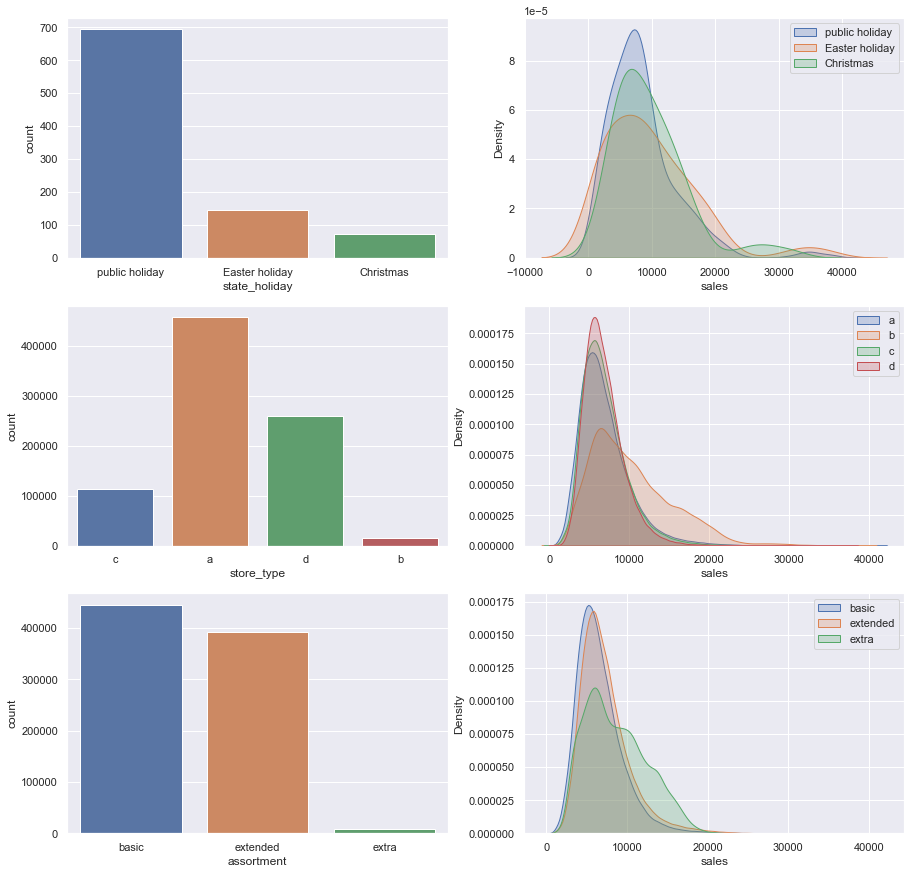

In [57]:
#state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']) #plotando a quanidade de linhas (vendas) para cada valor da variavel state_holiday'

plt.subplot(3,2,2)
sns.kdeplot(df4['sales'][df4['state_holiday'] == 'public holiday'], shade = True)# plotando a densidade 
#de sales para somente o valor 'public_holiday' da coluna 'state_holiday' no eixo x

sns.kdeplot(df4['sales'][df4['state_holiday'] == 'Easter holiday'], shade = True)# plotando a densidade 
#de sales para somente o valor 'Easter holiday'da coluna 'state_holiday' no eixo x

sns.kdeplot(df4['sales'][df4['state_holiday'] == 'Christmas'], shade = True)
plt.legend(['public holiday', 'Easter holiday', 'Christmas'])# plotando a densidade 
#de sales para somente o valor 'Christmas' da coluna 'state_holiday'no eixo x



#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type']) #plotando a quanidade de linhas (vendas) para cada valor da variavel store_type

plt.subplot(3,2,4)
sns.kdeplot(df4['sales'][df4['store_type'] == 'a'], shade = True)# plotando a densidade 
#de sales para somente o valor 'a' da coluna 'store_type' no eixo x

sns.kdeplot(df4['sales'][df4['store_type'] == 'b'], shade = True)# plotando a densidade 
#de sales para somente o valor 'b'da coluna 'store_type' no eixo x

sns.kdeplot(df4['sales'][df4['store_type'] == 'c'], shade = True)
plt.legend(['public holiday', 'Easter holiday', 'Christmas'])# plotando a densidade 
#de sales para somente o valor 'c' da coluna 'store_type'no eixo x

sns.kdeplot(df4['sales'][df4['store_type'] == 'd'], shade = True)
plt.legend(['a', 'b', 'c', 'd'])# plotando a densidade 
#de sales para somente o valor 'd' da coluna 'store_type'no eixo x



#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment']) #plotando a quanidade de linhas (vendas) para cada valor da variavel assortment'

plt.subplot(3,2,6)
sns.kdeplot(df4['sales'][df4['assortment'] == 'basic'], shade = True)# plotando a densidade 
#de sales para somente o valor 'basic' da coluna 'assortment' no eixo x

sns.kdeplot(df4['sales'][df4['assortment'] == 'extended'], shade = True)# plotando a densidade 
#de sales para somente o valor 'extended 'da coluna ''assortment' no eixo x

sns.kdeplot(df4['sales'][df4['assortment'] == 'extra'], shade = True)
plt.legend(['basic', 'extended', 'extra'])# plotando a densidade 
#de sales para somente o valor 'extras' da coluna 'assortment no eixo x

In [58]:
#state_holiday analise dos graficos
# Nestes dois graficos percebe que apesar de christmas ter um volume de vendas menor menor q easter holiday,
# christmas tem um pico maior que easter holiday, o q significa que apesar de vender menos q os outros tem uma densidade de cenda alta.

# enquanto no easter holiday, apesar de vender mais q cristmas, tem uma densidade de venda moderada, as vezes vende muito, as vezes vende pouco
# as vezes vende medio



#store_type analise dos graficos
# o tipo de loja a da coluna store_type, apesar de ter um volume de vendas alto, nao tem um pico tao grande, o q significa 
# que tem lojas do tipo a que vendem pouco, vendem medio, vendem alto, ou seja, e diversificado.

# enqunato lojas do tipo d tem alto concentracao de venda, ou seja, semprem vendem pouco, de acordo tbm com o primeiro grafico.



#store_type analise dos graficos
# extra vende pouco e tem um pico menor, mas tem uma distribuicao maior, o q significa q tem mais lojas com difentes 
# tipos de extra, tem lojas q vende mais com extra, tem lojas q vendem menos com extra.

In [59]:
nb extension no jupyter e procurar por hide, coloca hide input e skip-traceback, pretyfi

SyntaxError: invalid syntax (<ipython-input-59-cc4620736890>, line 1)

## 4.2. Analise Bivariada

### **H1.** Lojas com maior sortemento deveriam vender mais.
**Falsa** Lojas com MAIOR SORTEMENTO vendem MENOS.

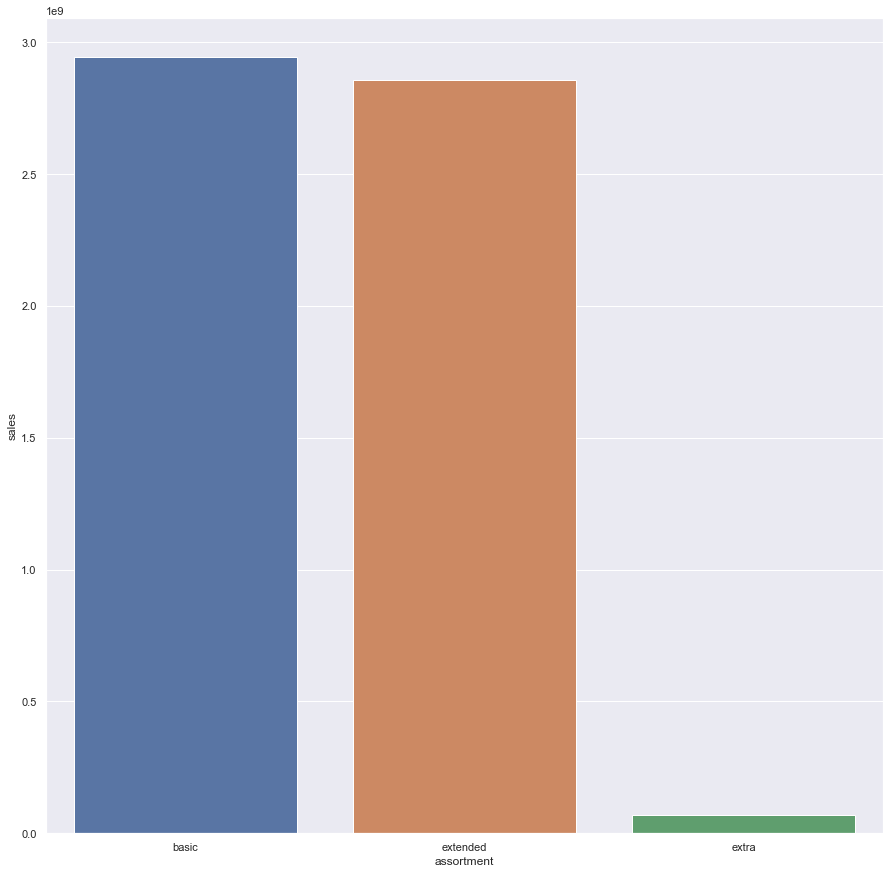

In [45]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

assortment     basic  extended   extra
year_week                             
2013-00     13434262  12425669  269404
2013-01     26007250  22917693  350279
2013-02     17970974  16029584  377207
2013-03     24392076  21243431  404662
2013-04     19972891  18130077  363061
...              ...       ...     ...
2015-26     27840342  27165959  684180
2015-27     20356210  20449036  586036
2015-28     25746704  25629698  632017
2015-29     19257263  19570832  574020
2015-30     23492454  23301780  436689

[137 rows x 3 columns]


<AxesSubplot:xlabel='year_week'>

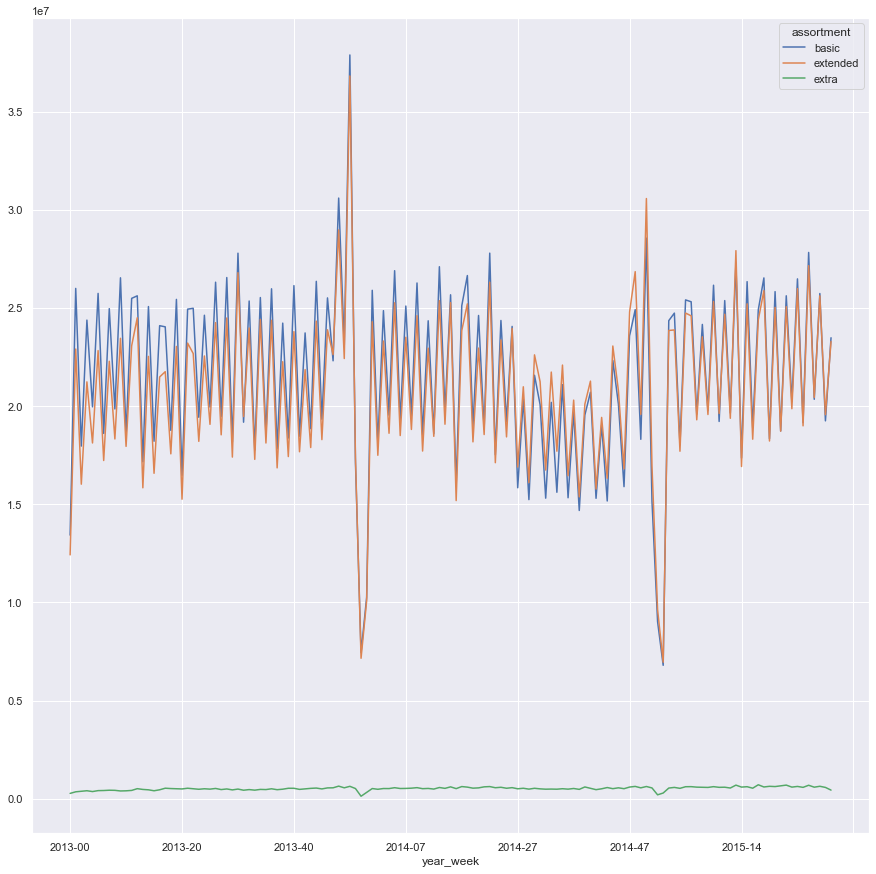

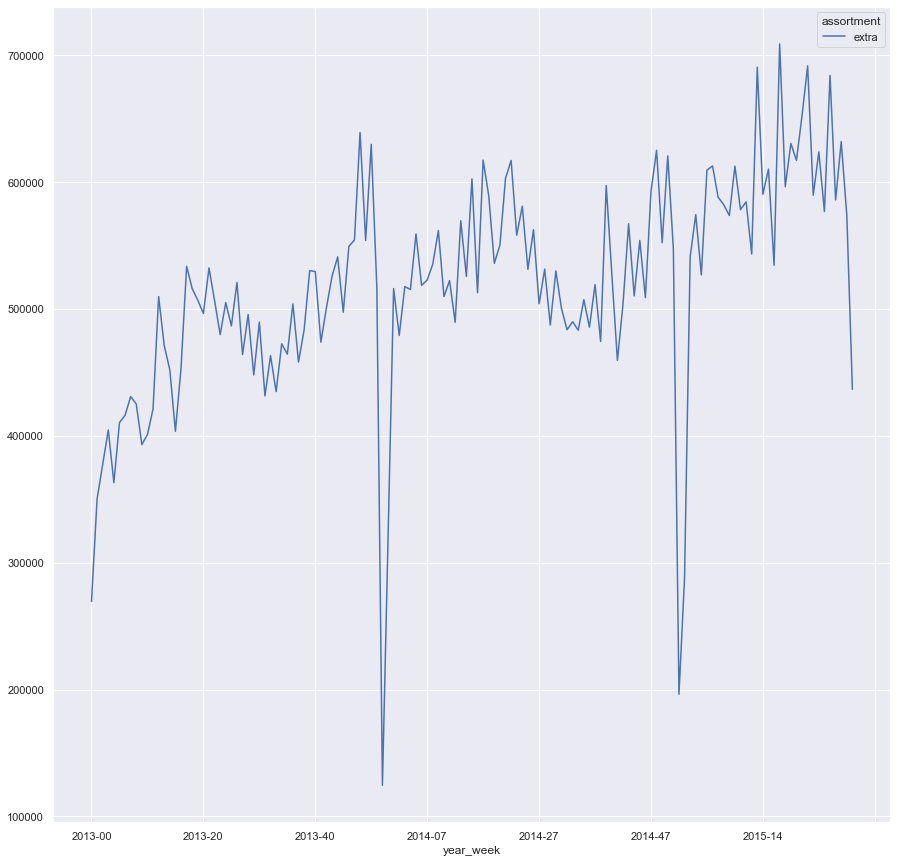

In [46]:
# VERIFICACAO SE A VARIAVEL SERA IMPORTANTE PARA O MODELO
# RESPOSTA : SIM SERA, POR CAUSA DO COMPORTAMENTO DO VALOR EXTRA

# vendas por semana do mes e por assortment
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux3 = aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales')
print(aux3)
aux3.plot()

aux4 = aux2[aux2['assortment'] == 'extra']
aux4.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

# quando tem uma discrepancia muito grande entre os valores, vale a pena plotar separado cada valor para poder enxergar algum 
# comportamento

#VARIAVEL RELEVANTE PARA O MODELO POIS TEM DOIS TIPOS DE COMPORTAMENTOS.

### **H2.** Lojas com competidores mais proximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

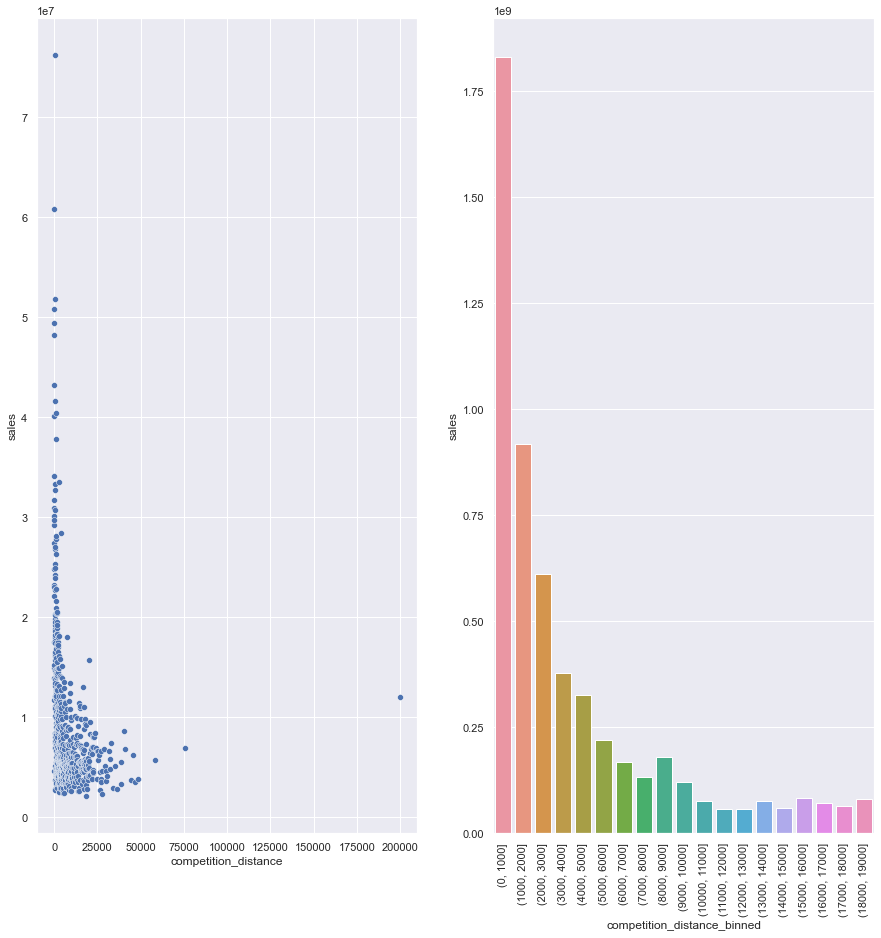

In [47]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,2,1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);


plt.subplot(1,2,2)
# para criar grupors de valores para a variavel competition_distance, por exemplo de 1000 em 1000 indo de 0 a 20000, 
#usa-se a funcao bin.
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)

aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation=90);

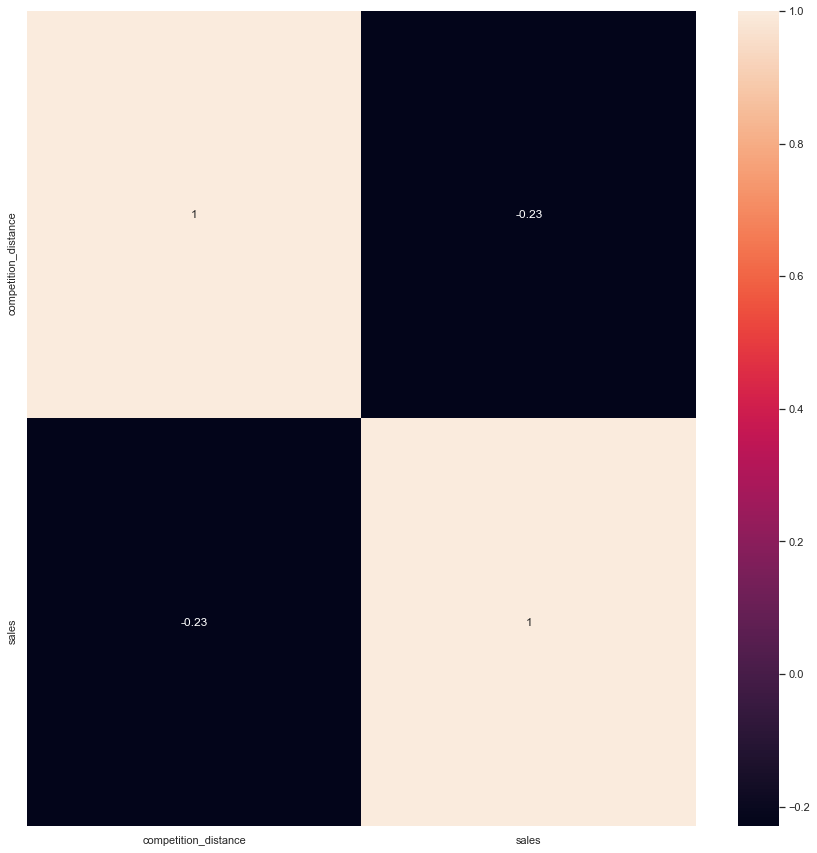

In [48]:
# VERIFICACAO SE A VARIAVEL SERA IMPORTANTE PARA O MODELO, correlacao antre a competition distance e vendas, 
# para ver o impacto de uma na outra.

# RESPOSTA : correlacao FRACA, pois quanto mais proximo de 1 ou -1 mais alta e a correlacao
#                                 quanto mais proximo de 0 mais fraca e a correcao
# - 0.23 significa quanto mais distante o competifor esta, menor a venda.
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### **H3.** Lojas com competidores a mais tempo deveriam vender mais.
**FALSA** Lojas com COMPETIDORES A MAIS TEMPO  vendem MENOS

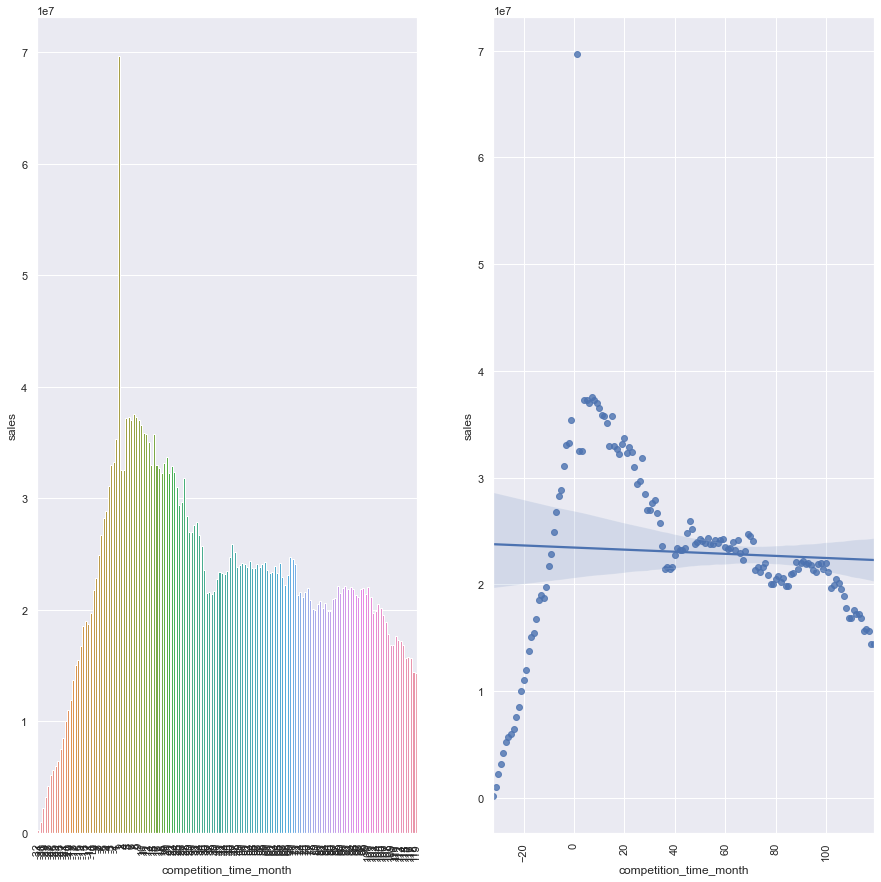

In [49]:
plt.subplot(1,2,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation=90);

plt.subplot(1,2,2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation=90);

# quanto amis recente e a competicao, maior e a venda

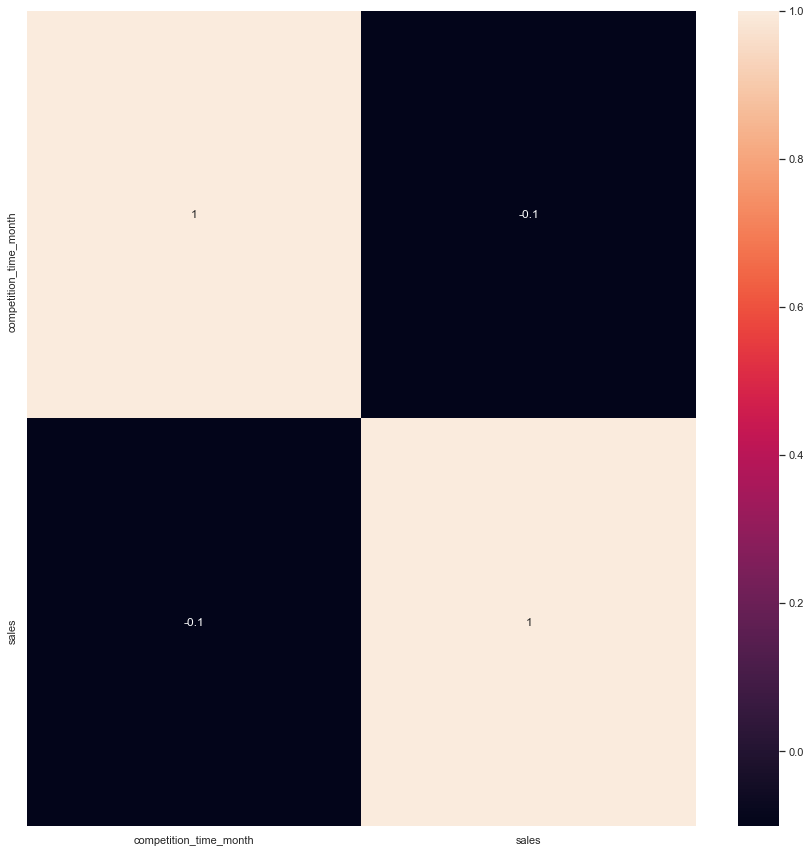

In [97]:
# VERIFICACAO SE A VARIAVEL SERA IMPORTANTE PARA O MODELO, correlacao antre a 'competition_time_month' e vendas, 
# para ver o impacto de uma na outra.

# RESPOSTA : correlacao FRACA, pois quanto mais proximo de 1 ou -1 mais alta e a correlacao
#                                 quanto mais proximo de 0 mais fraca e a correcao
# - 0.1 significa quanto mais tempo o competifor existe, menor a venda.
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### **H4**. Lojas com promocoes ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com PROMOCOES ATIVAS POR MAIS TEMPO vendem MENOS.

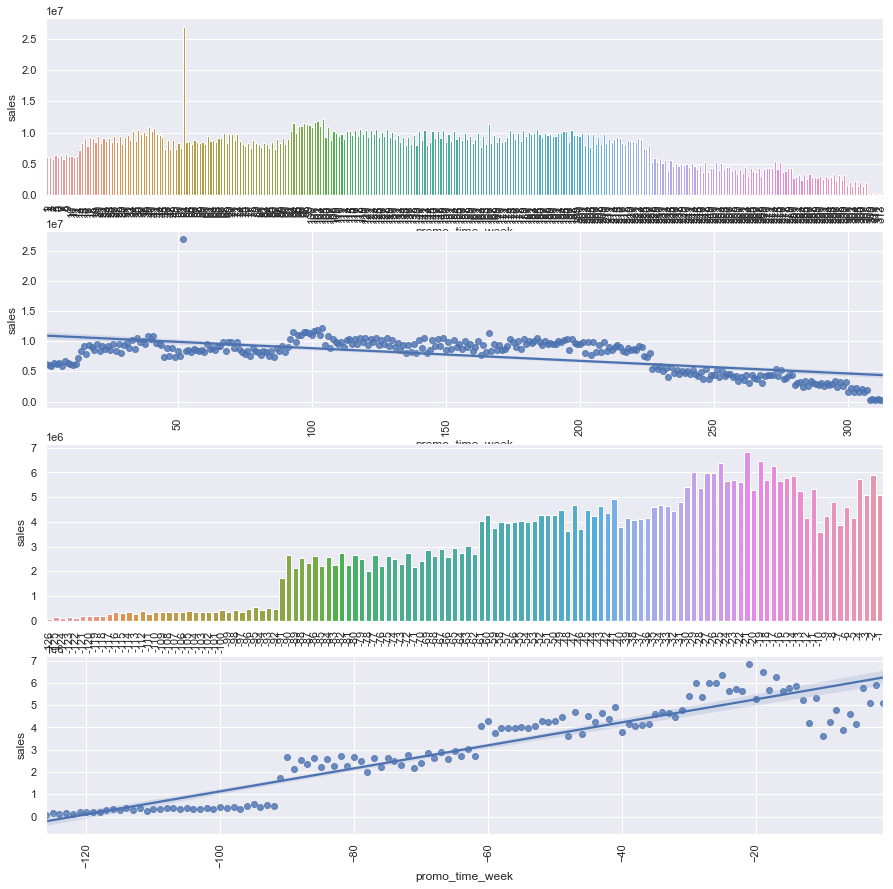

In [103]:
# obs: todo promo_time_week de valor positivo significa q a venda foi feita no periodo de promocao extendida, ja
#      todo promo_time_week de valor negativo significa q a venda foi feita antes do periodo de promocao extendida, e sim
#      foi feita no periodo de promocao regular ou no periodo de nao promocao.

aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.subplot(4,1,1)
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation=90);

plt.subplot(4,1,2)
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation=90);

plt.subplot(4,1,3)
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation=90);

plt.subplot(4,1,4)
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation=90);

# as lojas vendem bem ate certo tempo na promocao extendida depois cai

# as lojas tem um pico de vendas quanto mais se aproxima do inicio da promocao extendida


#para criar dashboard
# grid = GriSpec(2,3)
# plt.subplot(grid[0,1])

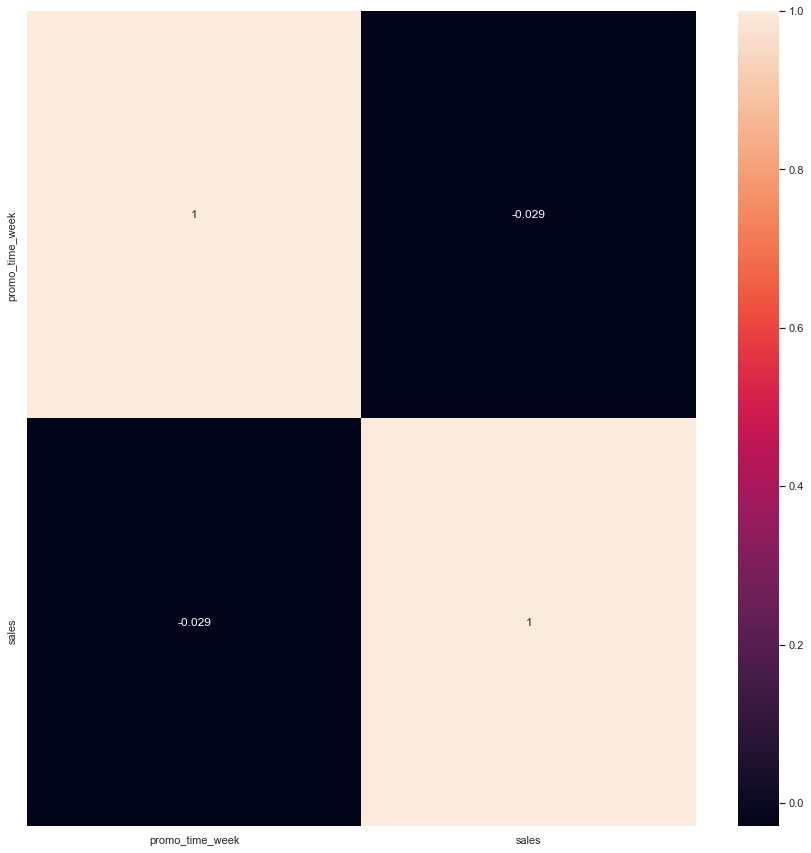

In [104]:
# VERIFICACAO SE A VARIAVEL SERA IMPORTANTE PARA O MODELO, correlacao antre a 'promo_time_week' e vendas, 
# para ver o impacto de uma na outra.

# RESPOSTA : correlacao bem fraca, pois quanto mais proximo de 1 ou -1 mais alta e a correlacao
#                                 quanto mais proximo de 0 mais fraca e a correcao
# - 0.029 significa quanto mais tempo o competifor existe, menor a venda.
# talves nem entre no modelo
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### <s>**H5.** Lojas com mais dias de promocao deveriam vender mais.</s>

### **H6.** Lojas com mais promocoes consecutivas deveriam vender mais.
**FALSA** Lojas com MAIS PROMOCOES CONSECUTIVAS vendem MENOS.

In [105]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


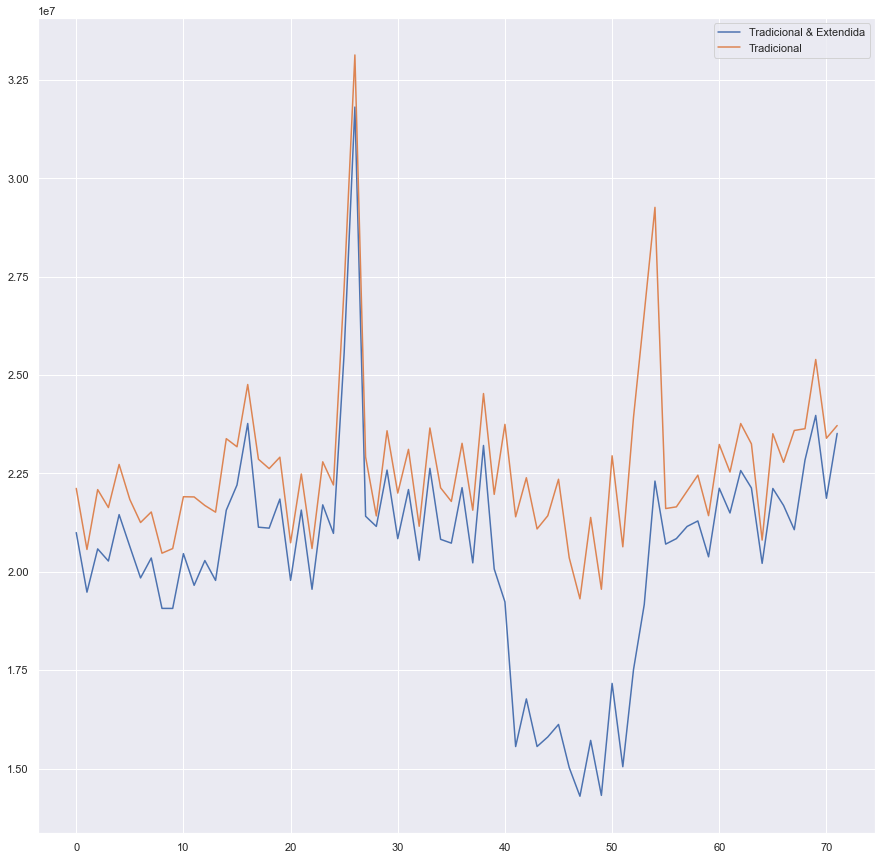

In [109]:
aux1 = df4[['year_week', 'sales']][(df4['promo'] == 1) & (df4['promo2'] == 1)].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[['year_week', 'sales']][(df4['promo'] == 1) & (df4['promo2'] == 0)].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels =['Tradicional & Extendida', 'Tradicional'])

# comportamento muito pountual para os dois, portanto essas variaveis TERAO UMA RELEVANCIA FRACA  para o modelo.

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado de Natal vendem menos.

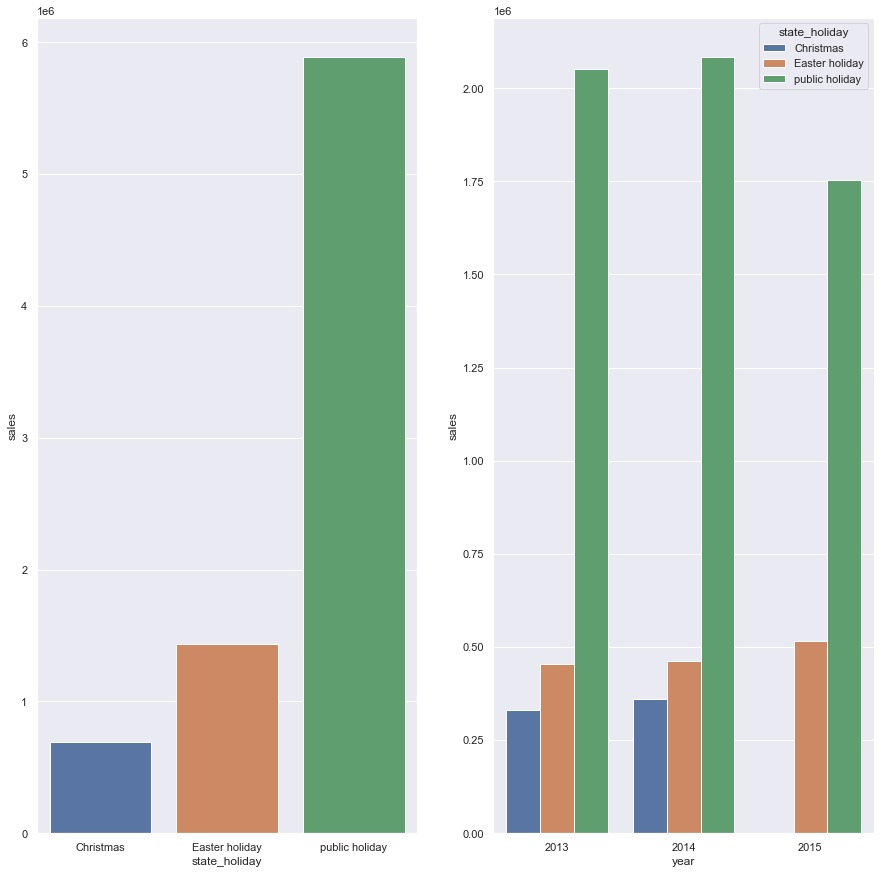

In [115]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux2);

# RELEVANTE PARA O MODELO.

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos.

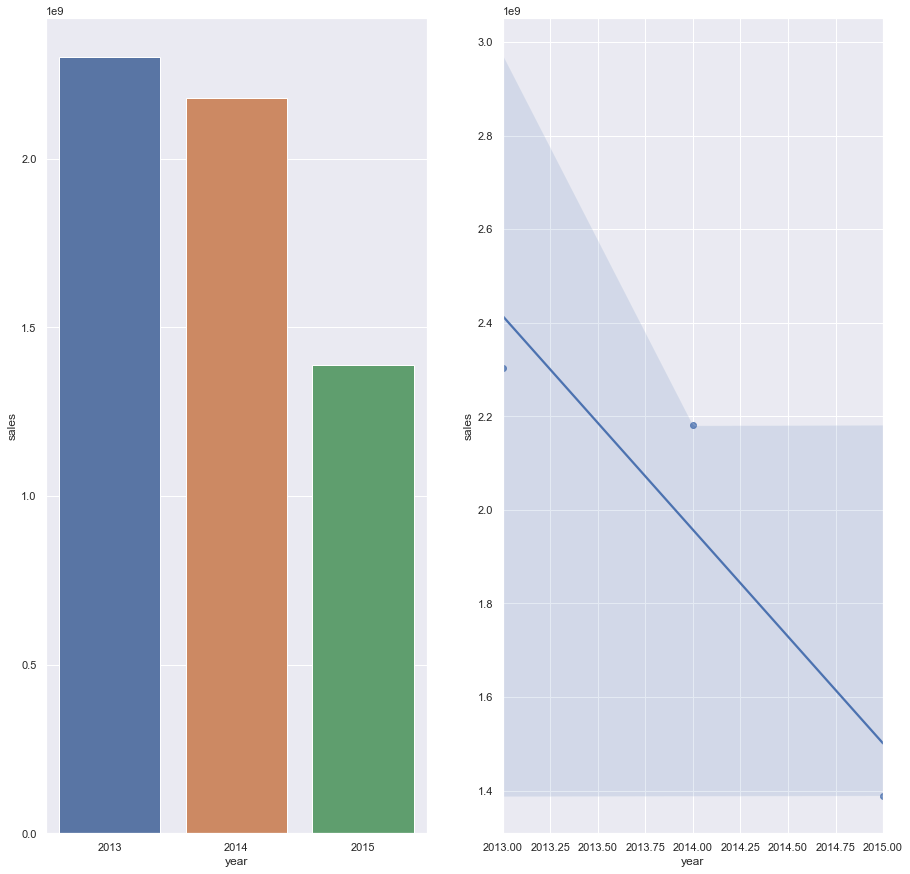

In [119]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1,2,2)
sns.regplot(x = 'year', y = 'sales', data = aux1);

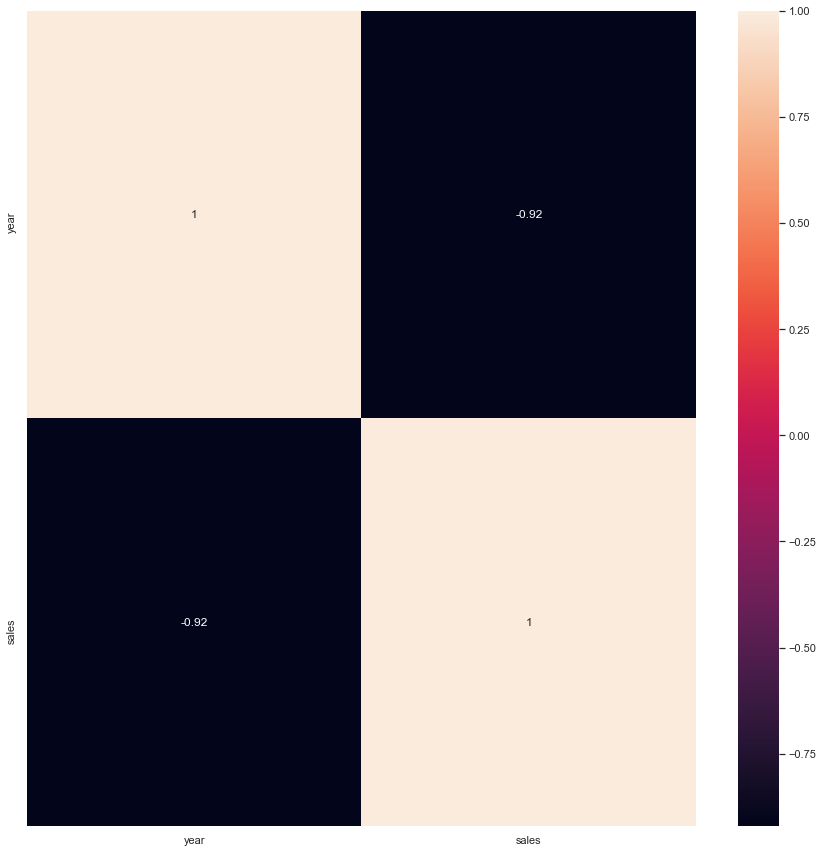

In [120]:
# VERIFICACAO SE A VARIAVEL SERA IMPORTANTE PARA O MODELO, correlacao antre a 'year' e vendas, 
# para ver o impacto de uma na outra.

# RESPOSTA : correlacao muito alta, pois quanto mais proximo de 1 ou -1 mais alta e a correlacao
#                                 quanto mais proximo de 0 mais fraca e a correcao
# - 0.92 significa quanto mais mais antigo, maior a venda.
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano.

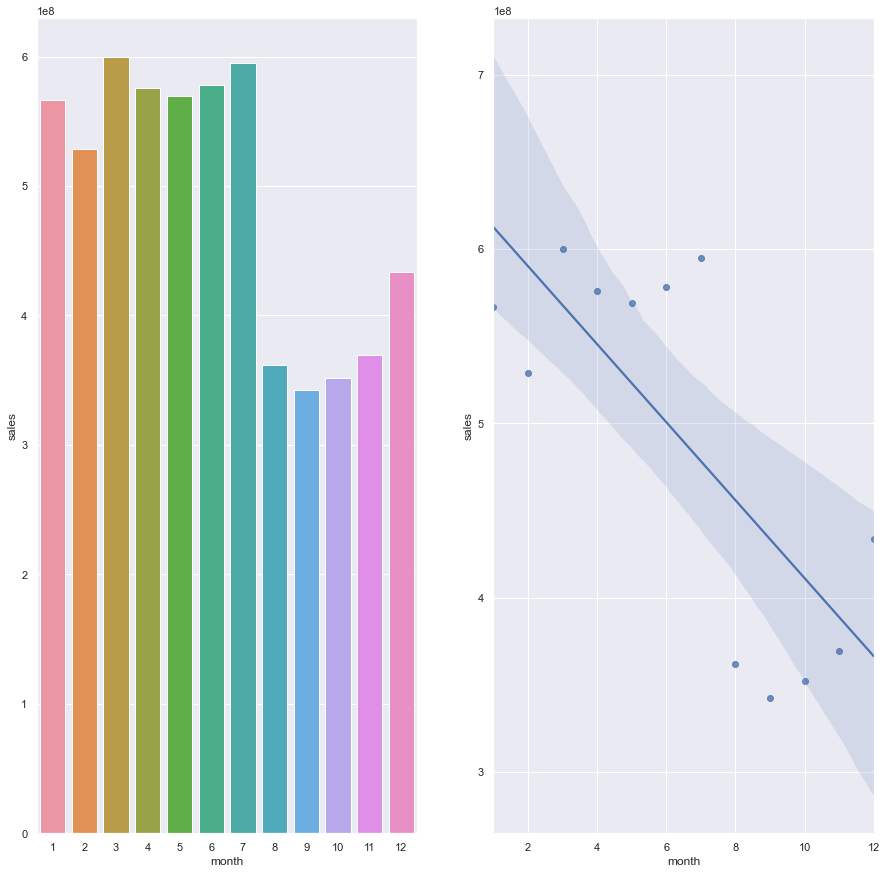

In [121]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1,2,2)
sns.regplot(x = 'month', y = 'sales', data = aux1);

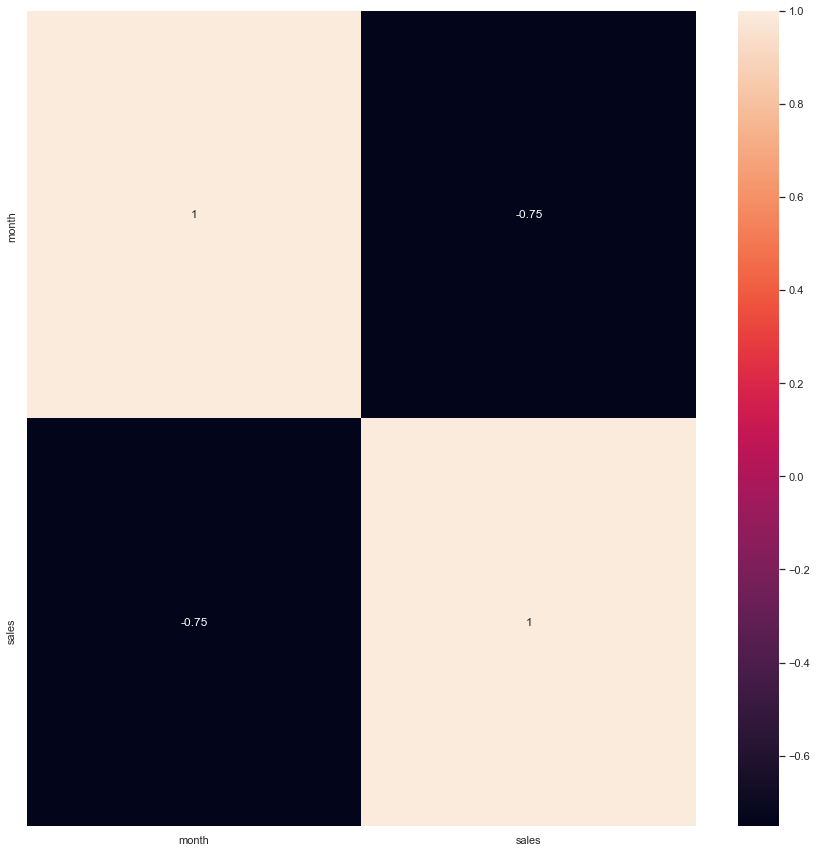

In [122]:
# VERIFICACAO SE A VARIAVEL SERA IMPORTANTE PARA O MODELO, correlacao antre a 'month' e vendas, 
# para ver o impacto de uma na outra.

# RESPOSTA : correlacao muito alta, pois quanto mais proximo de 1 ou -1 mais alta e a correlacao
#                                 quanto mais proximo de 0 mais fraca e a correcao
# - 0.75 significa quanto mais mais antigo, maior a venda.
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mes.
**VERDADEIRA** Lojas vendem mais depis do dia 10 de cada mes.

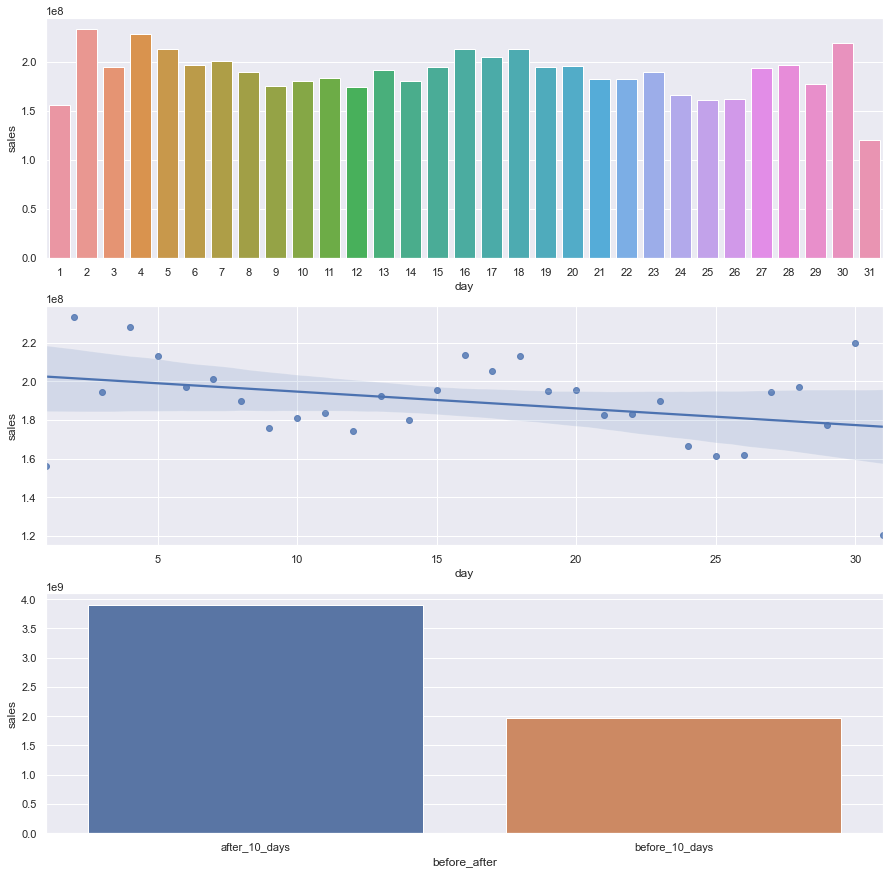

In [129]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(3,1,1)
sns.barplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(3,1,2)
sns.regplot(x = 'day', y = 'sales', data = aux1);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <=10 else
                                                    'after_10_days'                )

aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(3,1,3)
sns.barplot(x = 'before_after', y = 'sales', data = aux2);

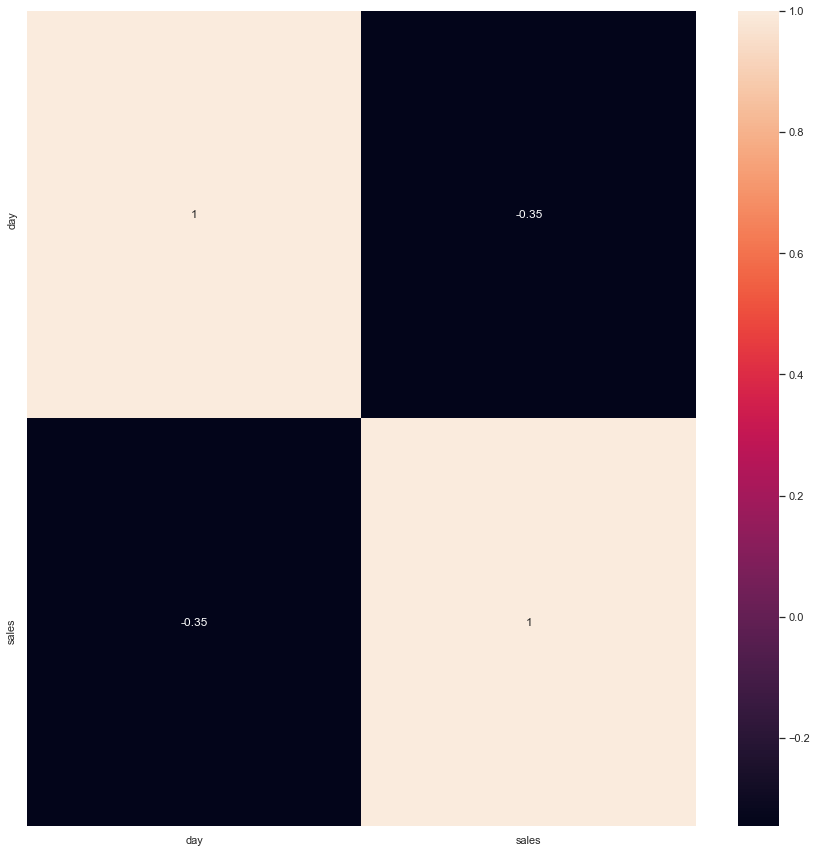

In [124]:
# VERIFICACAO SE A VARIAVEL SERA IMPORTANTE PARA O MODELO, correlacao antre a 'day' e vendas, 
# para ver o impacto de uma na outra.

# RESPOSTA : correlacao alta, pois quanto mais proximo de 1 ou -1 mais alta e a correlacao
#                                 quanto mais proximo de 0 mais fraca e a correcao
# - 0.35significa quanto mais mais antigo, maior a venda.
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### **H11.** Lojas deveriam vender menos aos fins de semana.
**VERDADEIRA** Lojas vendem menos nos fins de semana.

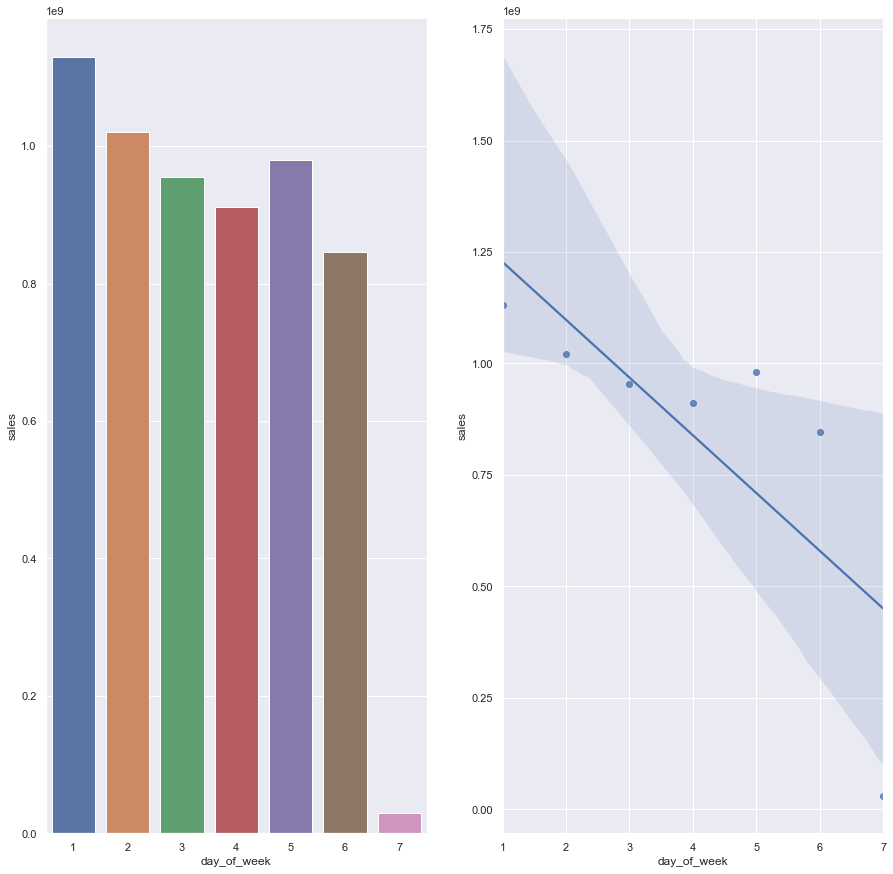

In [130]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1,2,2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1);

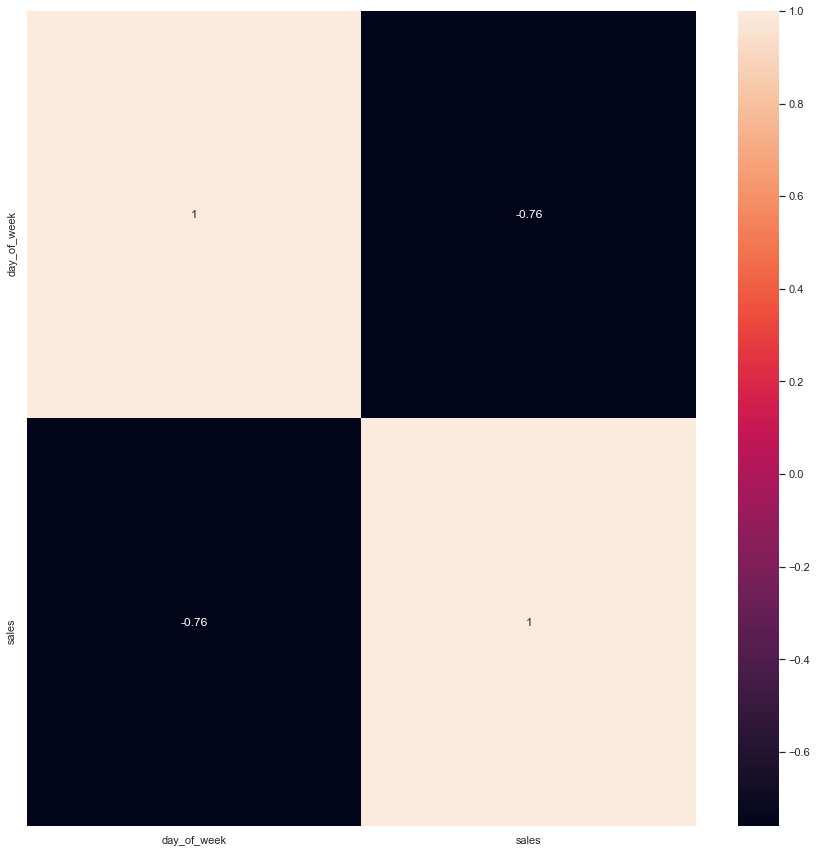

In [131]:
# VERIFICACAO SE A VARIAVEL SERA IMPORTANTE PARA O MODELO, correlacao antre a 'day_of_week' e vendas, 
# para ver o impacto de uma na outra.

# RESPOSTA : correlacao alta, pois quanto mais proximo de 1 ou -1 mais alta e a correlacao
#                                 quanto mais proximo de 0 mais fraca e a correcao
# - 0.76 significa quanto mais para o inicio da semana, maior a venda.
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto para os meses julho e agosto.

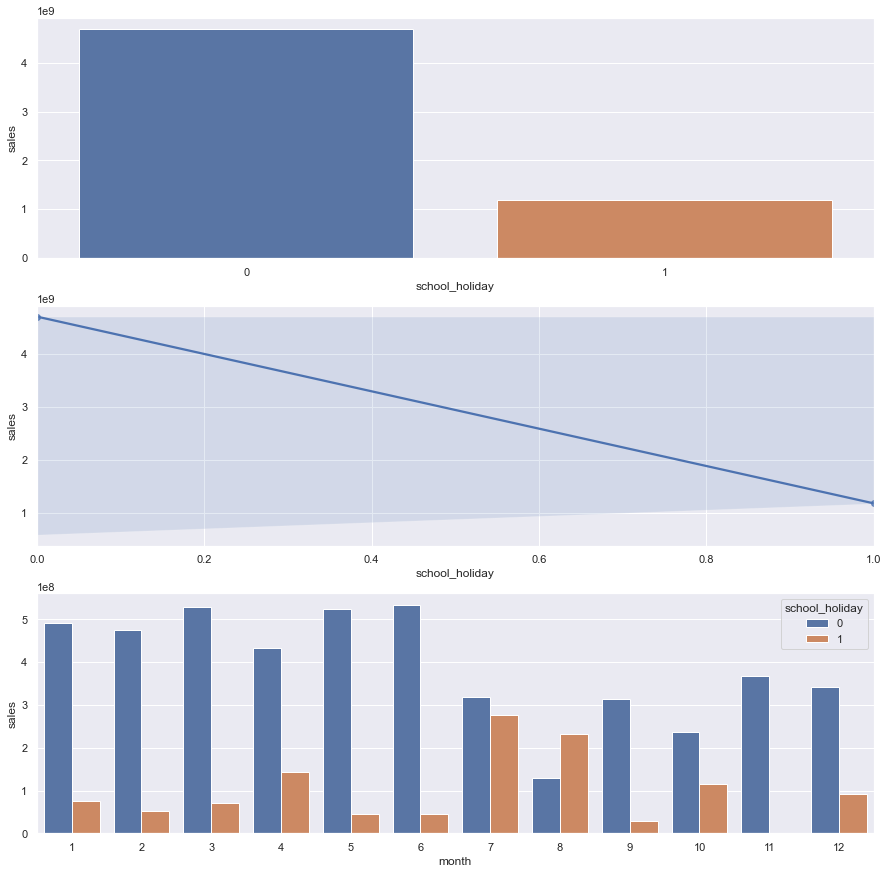

In [137]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(3,1,1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

plt.subplot(3,1,2)
sns.regplot(x = 'school_holiday', y = 'sales', data = aux1);

plt.subplot(3,1,3)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);

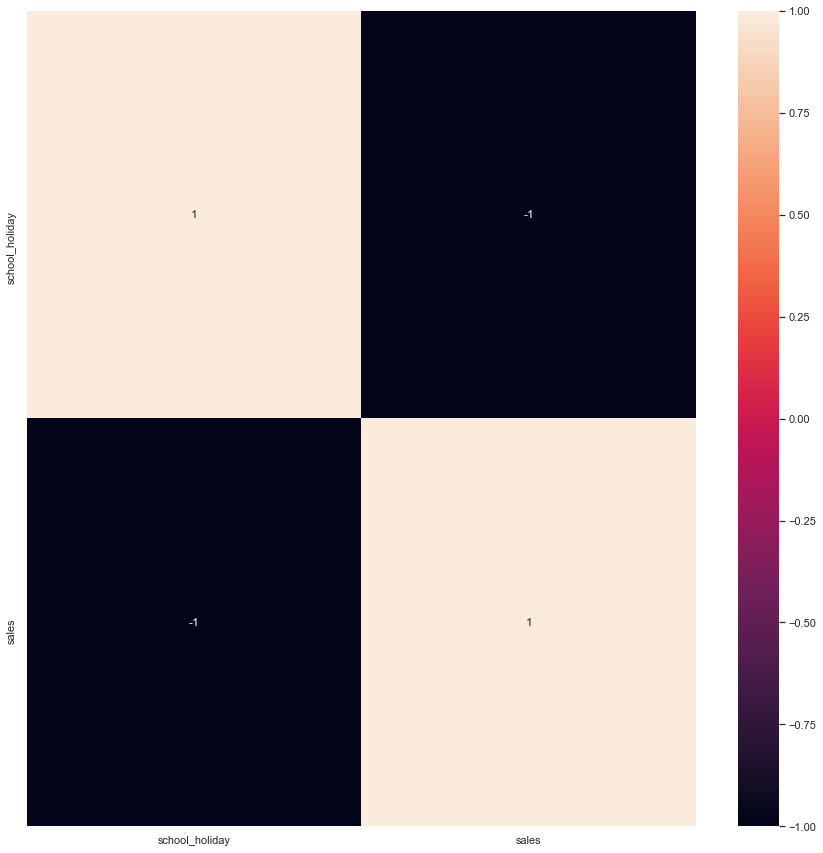

In [135]:
# variavel linear, por isso e um

# VERIFICACAO SE A VARIAVEL SERA IMPORTANTE PARA O MODELO, correlacao antre a 'school_holiday' e vendas, 
# para ver o impacto de uma na outra.

# RESPOSTA : correlacao alta, pois quanto mais proximo de 1 ou -1 mais alta e a correlacao
#                                 quanto mais proximo de 0 mais fraca e a correcao
# - 1 significa quanto mais para o inicio da semana, maior a venda.
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### 4.2.1. Resumo das Hipoteses.

In [60]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'False', 'Low'],
      ['H2', 'False', 'Medium'],
      ['H3', 'False', 'Medium'],
      ['H4', 'False', 'Low'],
      ['H5', '-', '-'],
      ['H6', 'False', 'Low'],
      ['H7', 'False', 'Medium'],
      ['H8', 'False', 'High'],
      ['H9', 'False', 'High'],
      ['H10', 'True', 'High'],
      ['H11', 'True', 'High'],
      ['H12', 'True', 'Low']]
print(tabulate(tab,headers = 'firstrow'))
       

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           False        Low
H2           False        Medium
H3           False        Medium
H4           False        Low
H5           -            -
H6           False        Low
H7           False        Medium
H8           False        High
H9           False        High
H10          True         High
H11          True         High
H12          True         Low


## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

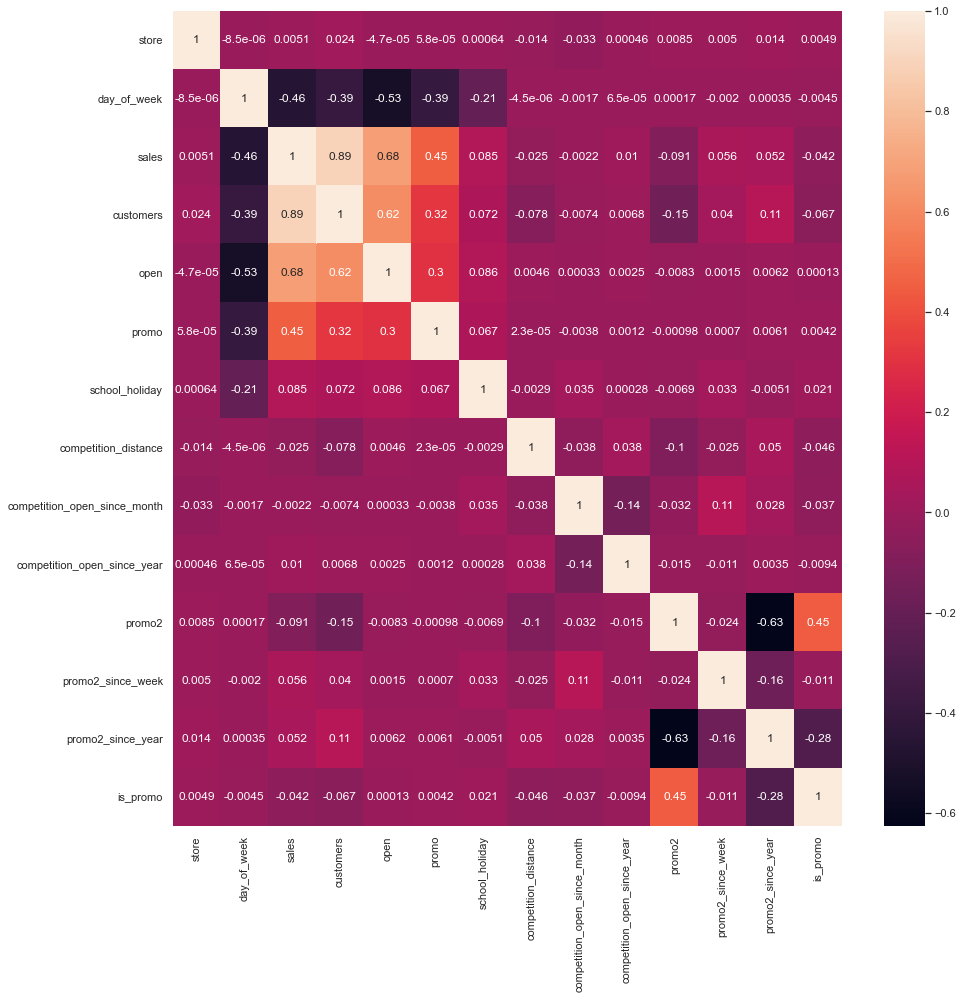

In [61]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

# mais perto da cor preto mais maior e a correlacao negativa
# mais perto da cor branca mais maior e a correlacao positiva

# methodo de pearson somente usado em variaveis numericas

### 4.3.1. Categorical Attributes

<AxesSubplot:>

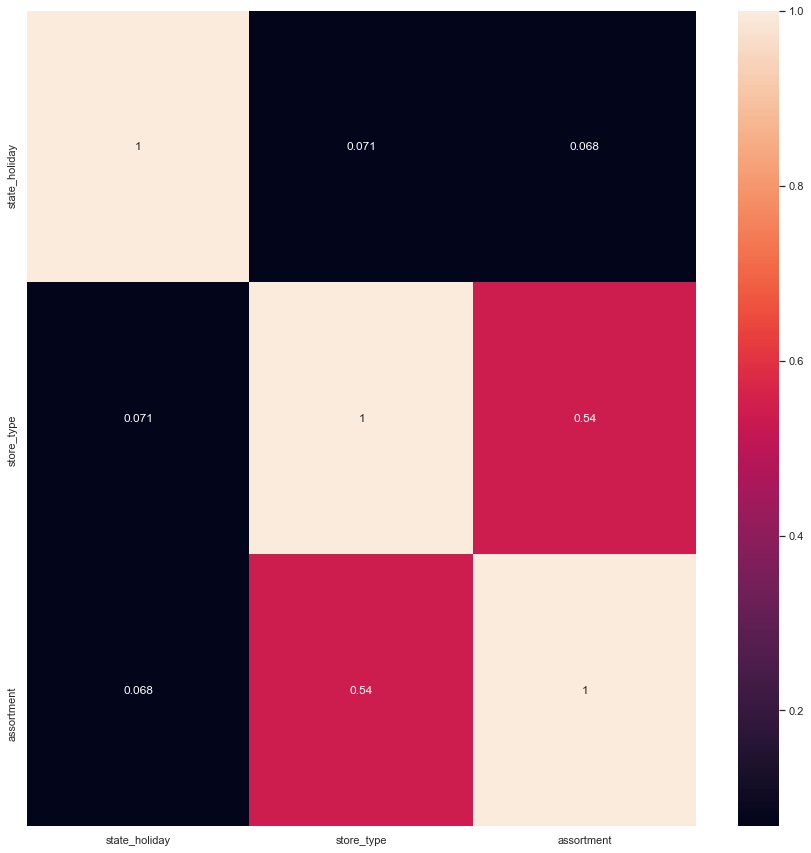

In [62]:
# only categorical data

a = df4.select_dtypes(include = 'object')

#calculate cramer v

# metodo utilizado: cruamer v
# vai de 0 a 1
# quanto mais perto do 0 menor a correlacao
# quanto mais perto do 1 maior a correlacao

a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])


#final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot = True)

# 5.0. STEP 05 - DATA PREPARATION

In [63]:
df5 = df4.copy()

## 5.1. Normalization

In [64]:
# como nao tem variaveis numericas com distribuicao normal, nao se usa a normalization entao.

## 5.2. Rescaling

In [65]:
a = df5.select_dtypes(include=['int64','float64'])

In [66]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.000,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.000,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.000,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.000,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.000,4,2015,0,31,2015,0,2015,7,31,31,4,0


C:\Users\Igor\anaconda3\envs\Data-Science-Em-Producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Igor\anaconda3\envs\Data-Science-Em-Producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Igor\anaconda3\envs\Data-Science-Em-Producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will re

<AxesSubplot:xlabel='year'>

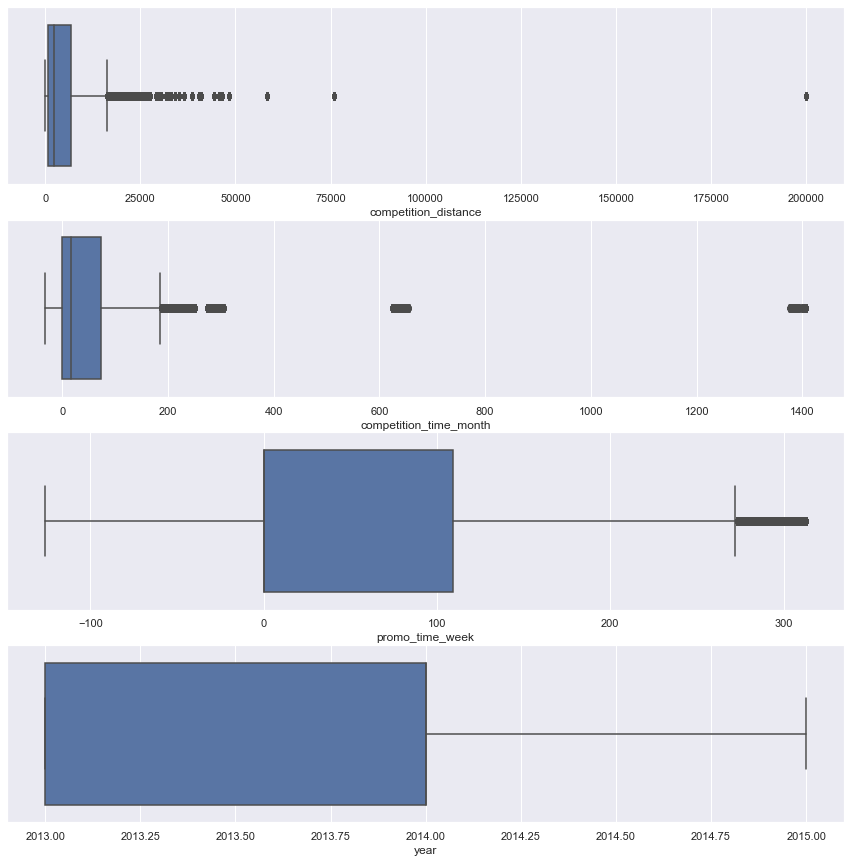

In [67]:
# competition_distance
plt.subplot(4,1,1)
sns.boxplot(df5['competition_distance'])

# utilizara o robust scaler pois tem muitos outliers

# competition_time_month
plt.subplot(4,1,2)
sns.boxplot(df5['competition_time_month'])

# utilizara o robust scaler pois tem muitos outliers

# # promo_time_week
plt.subplot(4,1,3)
sns.boxplot(df5['promo_time_week'])

# utilizara o Min-Max scaler pois tem muitos outliers, pois os outiers nao sao tao grandes

# # year
plt.subplot(4,1,4)
sns.boxplot(df5['year'])

# utilizara o Min-Max scaler pois tem muitos outliers, pois nao tem outliers

In [68]:
# competition_distance uses Robust Scaler
rs = RobustScaler()
mms = MinMaxScaler()

df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_time_month uses Robust Scaler
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo_time_week uses Robust Scaler
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year uses Min-Max Scaler
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3. TRansformation

### 5.3.1. Encoding

In [69]:
# state_holiday
# como e uma variavel que apresenta ideia de estado, usa-se o one hot encoding
df5 = pd.get_dummies(df5,prefix=['state_holiday'], columns=['state_holiday'])

# store_type
# como e uma variavel que nao apresenta ordem ou escala, cada valor e independente, usa-se o one label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment
# como e uma variavel que apresenta ordem ou escala, usa-se o ordinal encoding
assortment_dict = {'basic' : 1, 'extra' : 2, 'extended' : 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

In [70]:
#transformacao de gradeza da variavel resposta
df5['sales'] = np.log1p(df5['sales'])

### 5.3.2 Nature Rtansformation

In [71]:
# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30))) # 30 pois e a quantidade de dias do mes
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7))) # 7 pois e a quantidade de dias da semana
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12))) # 12 pois e a quantidade de meses existentes
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52))) # 52 pois e a quantidade de semanas do ano
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

In [72]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public holiday,state_holiday_regular_day,day_sin,day_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.569,1,1,2,1,-0.171,9,...,0,1,0.208,0.978,-0.975,-0.223,-0.500,-0.866,-0.568,-0.823
1,2,5,2015-07-31,8.710,1,1,0,1,-0.284,11,...,0,1,0.208,0.978,-0.975,-0.223,-0.500,-0.866,-0.568,-0.823
2,3,5,2015-07-31,9.026,1,1,0,1,1.903,12,...,0,1,0.208,0.978,-0.975,-0.223,-0.500,-0.866,-0.568,-0.823
3,4,5,2015-07-31,9.547,1,1,2,3,-0.276,9,...,0,1,0.208,0.978,-0.975,-0.223,-0.500,-0.866,-0.568,-0.823
4,5,5,2015-07-31,8.481,1,1,0,1,4.448,4,...,0,1,0.208,0.978,-0.975,-0.223,-0.500,-0.866,-0.568,-0.823


# 6.0. STEP 06 - FEATURE SELECTION

In [87]:
df6 = df5.copy()

## 6.1. Split Dataframe Into Training and Test Dataset

In [88]:
# primeiro deleta-se variaveis originais que originaram variavies derivadas, elas sao deletadas pois contem mesma informacao
# que as derivadas.

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis =1)

In [89]:
# split training and test
# como as vendas sao em ralacao ao tempo, e se quer fazer uma previsao pra 6 semanas, entao vamos pegar as ultimas 6 semanas
# como teste. Logo o periodo anterior as ultimas 6 semanas servira como treino.
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

#dados de treino ate o dia 2015-06-18
#dados de teste a partir do dia 2015-06-19

Timestamp('2015-06-19 00:00:00')

In [91]:
# training dataset onde x sao as features e y e a label(variavel resposta)
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

# test dataset onde x sao as features e y e a label(variavel resposta)
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [94]:
# training and test dataset for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis = 1).values # date e sales nao sao inclusos no processo do boruta
Y_train_n = Y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs = -1)

#define Boruta
boruta = BorutaPy(rf,n_estimators='auto',verbose=2, random_state=42).fit(X_train_n,Y_train_n)

# Iteration: 	1 / 100
# Confirmed: 	0
# Tentative: 	27
# Rejected: 	0
# Iteration: 	2 / 100
# Confirmed: 	0
# Tentative: 	27
# Rejected: 	0
# Iteration: 	3 / 100
# Confirmed: 	0
# Tentative: 	27
# Rejected: 	0
# Iteration: 	4 / 100
# Confirmed: 	0
# Tentative: 	27
# Rejected: 	0
# Iteration: 	5 / 100
# Confirmed: 	0
# Tentative: 	27
# Rejected: 	0
# Iteration: 	6 / 100
# Confirmed: 	0
# Tentative: 	27
# Rejected: 	0
# Iteration: 	7 / 100
# Confirmed: 	0
# Tentative: 	27
# Rejected: 	0
# Iteration: 	8 / 100
# Confirmed: 	18
# Tentative: 	0
# Rejected: 	9


# BorutaPy finished running.

# Iteration: 	9 / 100
# Confirmed: 	18
# Tentative: 	0
# Rejected: 	9

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1 Best Features from Boruta

In [95]:
# selecionando as variaveis que ele rankiou como sendo as mais relevantes
cols_selected = boruta.support_.tolist()# mostra os valores de cada coluna, rankeando do 1(mais relevante) para 2, 3, 4, etc

#best features (como saber as colunas selecionadas)
X_train_fs = X_train.drop(['date', 'sales'],axis = 1) # date e sales nao sao inclusos no processo do boruta
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list() # mostrando o nome das colunas no rank

# not selected boruta (como saber as colunas nao selecionadas)
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [96]:
# lista de coluna selecionadas pelo boruta
cols_selected_boruta

# ['store',
#  'promo',
#  'store_type',
#  'assortment',
#  'competition_distance',
#  'competition_open_since_month',
#  'competition_open_since_year',
#  'promo2',
#  'promo2_since_week',
#  'promo2_since_year',
#  'competition_time_month',
#  'promo_time_week',
#  'day_sin',
#  'day_cos',
#  'day_of_week_sin',
#  'day_of_week_cos',
#  'month_cos',
#  'week_of_year_cos']

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'week_of_year_cos']

In [97]:
# lista de coluna nao selecionadas pelo boruta
cols_not_selected_boruta

# ['is_promo',
#  'month_sin',
#  'school_holiday',
#  'state_holiday_Christmas',
#  'state_holiday_Easter holiday',
#  'state_holiday_public holiday',
#  'state_holiday_regular_day',
#  'week_of_year_sin',
#  'year']

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_Christmas',
 'state_holiday_Easter holiday',
 'state_holiday_public holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

In [ ]:
# Agora se compara as variaveis do boruta com as variavies do EDA.

# Quando da discrepancia na analise de importancia entre a analise exploratoria de dados e o boruta,
# no primeiro ciclo do crisp, se da preferencia ao boruta, nos ciclos seguintes adiciona a variavel q foi dita como importante 
# na EDA.
# Exemplo: o ano e relevante na EDA mas nao e relevante no boruta, enta primeiro cria-se um modelo de ML sem a coluna ano,
# e no segundo ciclo adiciona o ano pra verificar se a acuracia melhorou ou nao.

## 6.3. Manual Feature Selection

In [100]:
cols_not_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_not_selected_boruta.extend(feat_to_add)

In [101]:
cols_not_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']